# CFP Propensity Version 1.0

### LIBRARY IMPORTS

In [1]:
'''Importing Required Libraries'''
import copy
from collections import OrderedDict
import pandas as pd
import lightgbm as lgb
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier,SGDRegressor
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
import joblib

### DATA IMPORT

In [2]:
'''Importing the data for modelling'''
# cfp_data = pd.read_csv(r"D:\Dbeaver Out\CFP_metrics_Green_202302091523.csv", na_values=['',' ','NH', 'NA', '[]'], low_memory=False)
# cfp_data = pd.read_csv(r"D:\Dbeaver Out\CFU_DataRed_Subs_DecJan_202302141641.csv", na_values=['',' ','NH', 'NA', '[]'], low_memory=False)
# cfp_data = pd.read_csv(r"D:\Dbeaver Out\CFP_TrainData_Green_DecJan_202302131645.csv", na_values=['',' ','NH', 'NA', '[]'], low_memory=False)
cfp_data = pd.read_csv(r"D:\Dbeaver Out\CFP_Data_Red_3Fixed_202302201426.csv", na_values=['',' ','NH', 'NA', '[]'], low_memory=False)

In [3]:
cfp_data.drop(['reff_88','reff_07', 'ref_390', 'ref_prod_disb'],axis=1,inplace=True) 

In [4]:
cfp_data.shape

(51090, 86)

In [5]:
cfp_data.columns

Index(['user_id', 'ltd', 'customer_type', 'nsaleable', 'latest_login_date',
       'salary_account', 'cfp_subscribed', 'monthly_income', 'credit_score',
       'age', 'pincode', 'marital_status', 'employment_type',
       'first_profile_date', 'latest_profile_date', 'city_band',
       'ptp_last_three_months_flag', 'positive_response_rate',
       'contactability', 'email_login_flag', 'unique_days_logged_in_flag',
       'sms_login_flag', 'last_login_vintage', 'negative_status_flag',
       'settled_flag', 'open_total_ratio', 'totl_neg_ratio',
       'saleable_accounts_count', 'cfp_interest', 'auto_loan_count',
       'gold_loan_count', 'consumer_loan_count', 'housing_loan_count',
       'credit_card_count', 'personal_loan_count', 'two_wheeler_count',
       'open_accounts', 'open_bank_fintech', 'open_bank_nbfc',
       'closed_accounts', 'settled_accounts', 'written_off_accounts',
       'flows_accounts', 'secured', 'unsecured', 'open_negative_status_count',
       'individual_account

In [6]:
# cfp_data.drop(['last_login_vintage',''],axis=1,inplace=True)

In [7]:
cfp_data.head()

,user_id,ltd,customer_type,nsaleable,latest_login_date,salary_account,cfp_subscribed,monthly_income,credit_score,age,pincode,marital_status,employment_type,first_profile_date,latest_profile_date,city_band,ptp_last_three_months_flag,positive_response_rate,contactability,email_login_flag,unique_days_logged_in_flag,sms_login_flag,last_login_vintage,negative_status_flag,settled_flag,open_total_ratio,totl_neg_ratio,saleable_accounts_count,cfp_interest,auto_loan_count,gold_loan_count,consumer_loan_count,housing_loan_count,credit_card_count,personal_loan_count,two_wheeler_count,open_accounts,open_bank_fintech,open_bank_nbfc,closed_accounts,settled_accounts,written_off_accounts,flows_accounts,secured,unsecured,open_negative_status_count,individual_account,joint_account,total_amt_sanctioned,total_balance,credit_limit,repayment_tenure,total_emi_amount,hdfc_neg_flag,citi_neg_flag,sbi_neg_flag,icici_neg_flag,cc_neg_flag,pl_neg_flag,cl_neg_flag,auto_loan_close_count_last3mnths,gold_loan_close_count_last3mnths,consumer_loan_close_count_last3mnths,housing_loan_close_count_last3mnths,credit_card_close_count_last3mnths,personal_loan_close_count_last3mnths,two_wheeler_close_count_last3mnths,individual_close_account_last3mnths,closed_accounts_last3mnths,secured_close_last3mnths,unsecured_close_last3mnths,negative_status_close_count_last3mnths,joint_account_close_last3mnths,max_score,score_on_m9,score_on_m3,score_on_m12,score_on_m6,neg_acc_on_m9,neg_acc_on_m3,neg_acc_on_m12,neg_acc_on_m6,max_dpd_on_m9,max_dpd_on_m3,max_dpd_on_m12,max_dpd_on_m6
0,24439938,2301,Red,0,2023-01-02 11:31:27.000,NaN,1,27268.44,725,34.00,144628.00,Married,NaN,2022-05-03 18:49:46.000,2022-12-08 21:05:42.000,Missing/Others,0.00,0.00,1.00,MoreThanOnce,MoreThanThree,MoreThanOnce,M1toM2,One,1,0.44,25.00,0,1.00,0.00,0.00,1.00,0.00,0.00,8.00,0.00,4.00,0,0,5.00,5.00,0.00,4.00,0.00,9.00,1.00,9.00,0.00,76.00,24.00,NaN,5.00,13097.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,675.00,725.00,NaN,725.00,1.00,1.00,NaN,1.00,0.00,0.00,NaN,0.00
1,19588060,2301,Red,0,2022-12-01 14:37:46.000,NaN,0,17274.09,575,35.00,110019.00,Single,Self Employed,2020-02-21 12:55:01.000,2022-12-01 14:37:52.000,Delhi/NCR,NaN,0.00,0.00,Zero,MoreThanThree,MoreThanOnce,M1toM2,One,1,0.36,12.50,0,0.00,0.00,2.00,3.00,0.00,2.00,15.00,0.00,8.00,0,0,14.00,13.00,1.00,8.00,2.00,20.00,1.00,22.00,0.00,44.00,12.00,2.00,28.00,43449.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725,725.00,575.00,NaN,600.00,0.00,2.00,NaN,0.00,0.00,0.00,NaN,0.00
2,26851618,2212,Red,0,2022-11-26 19:09:10.000,NaN,1,25000.00,675,30.00,396230.00,Married,Salaried,2022-09-24 17:22:20.000,2022-10-28 15:06:11.000,Missing/Others,0.00,0.33,0.43,MoreThanOnce,MoreThanThree,MoreThanOnce,M1toM2,One,1,0.50,25.00,0,1.00,0.00,0.00,2.00,0.00,0.00,5.00,0.00,4.00,0,0,4.00,4.00,0.00,4.00,0.00,8.00,1.00,8.00,0.00,48.00,14.00,NaN,6.00,13879.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,675,NaN,675.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,0.00,NaN,NaN
3,27603975,2301,Red,0,2022-12-27 17:30:32.000,NaN,0,15000.00,500,22.00,277123.00,NaN,Salaried,2022-11-07 16:39:24.000,2022-12-09 21:45:06.000,Missing/Others,0.00,1.00,0.50,MoreThanOnce,MoreThanThree,MoreThanOnce,M1toM2,MoreThanThree,1,0.00,NaN,0,0.00,0.00,0.00,1.00,0.00,0.00,4.00,0.00,0.00,0,0,5.00,4.00,1.00,0.00,0.00,5.00,0.00,5.00,0.00,7.00,NaN,NaN,2.00,2261.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500,NaN,500.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,0.00,NaN,NaN
4,16421209,2212,Red,0,2022-11-02 16:07:42.000,NaN,0,19052.08,675,39.00,226003.00,Single,Salaried,2019-07-13 08:28:17.000,2022-10-12 19:03:49.000,Missing/Others,0.00,0.00,0.00,Zero,Two,One,M1toM2,One,1,0.75,16.67,0,1.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,6.00,0,0,2.00,3.00,0.00,5.00,2.00,6.00,1.00,7.00,1.00,78.00,14.00,NaN,19.00,7342.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,N

In [8]:
'''Capping'''
cfp_data['age'] = np.where(cfp_data['age']<16,16,cfp_data['age'])
cfp_data['age'] = np.where(cfp_data['age']>42,42,cfp_data['age'])
cfp_data['monthly_income'] = np.where(cfp_data['monthly_income']>33000,33000,cfp_data['monthly_income'])
cfp_data['credit_score'] = np.where(cfp_data['credit_score']>750,750,cfp_data['credit_score'])
cfp_data['auto_loan_count'] = np.where(cfp_data['auto_loan_count']>2,2,cfp_data['auto_loan_count'])
cfp_data['gold_loan_count'] = np.where(cfp_data['gold_loan_count']>9,9,cfp_data['gold_loan_count'])
# cfp_data['consumer_loan_count'] = np.where(cfp_data['consumer_loan_count']>3,3,cfp_data['consumer_loan_count'])
cfp_data['housing_loan_count'] = np.where(cfp_data['housing_loan_count']>1,1,cfp_data['housing_loan_count'])
# cfp_data['credit_card_count'] = np.where(cfp_data['credit_card_count']>4,4,cfp_data['credit_card_count'])
# cfp_data['personal_loan_count'] = np.where(cfp_data['personal_loan_count']>2,2,cfp_data['personal_loan_count'])
cfp_data['two_wheeler_count'] = np.where(cfp_data['two_wheeler_count']>2,2,cfp_data['two_wheeler_count'])
# cfp_data['open_accounts'] = np.where(cfp_data['open_accounts']>7,7,cfp_data['open_accounts'])
cfp_data['open_bank_fintech'] = np.where(cfp_data['open_bank_fintech']>1,1,cfp_data['open_bank_fintech'])
cfp_data['open_bank_nbfc'] = np.where(cfp_data['open_bank_nbfc']>2,2,cfp_data['open_bank_nbfc'])
# cfp_data['closed_accounts'] = np.where(cfp_data['closed_accounts']>5,5,cfp_data['closed_accounts'])
cfp_data['settled_accounts'] = np.where(cfp_data['settled_accounts']>5,5,cfp_data['settled_accounts'])
cfp_data['written_off_accounts'] = np.where(cfp_data['written_off_accounts']>5,5,cfp_data['written_off_accounts'])
cfp_data['flows_accounts'] = np.where(cfp_data['flows_accounts']>5,5,cfp_data['flows_accounts'])
# cfp_data['secured'] = np.where(cfp_data['secured']>1,1,cfp_data['secured'])
# cfp_data['unsecured'] = np.where(cfp_data['unsecured']>1,1,cfp_data['unsecured'])
cfp_data['open_negative_status_count'] = np.where(cfp_data['open_negative_status_count']>5,5,cfp_data['open_negative_status_count'])
cfp_data['individual_account'] = np.where(cfp_data['individual_account']>5,5,cfp_data['individual_account'])
cfp_data['joint_account'] = np.where(cfp_data['joint_account']>5,5,cfp_data['joint_account'])
cfp_data['total_amt_sanctioned'] = np.where(cfp_data['total_amt_sanctioned']>200,200,cfp_data['total_amt_sanctioned'])
cfp_data['total_balance'] = np.where(cfp_data['total_balance']>50,50,cfp_data['total_balance'])
cfp_data['credit_limit'] = np.where(cfp_data['credit_limit']>20,20,cfp_data['credit_limit'])
cfp_data['repayment_tenure'] = np.where(cfp_data['repayment_tenure']>12,12,cfp_data['repayment_tenure'])
cfp_data['total_emi_amount'] = np.where(cfp_data['total_emi_amount']>20000,20000,cfp_data['total_emi_amount'])
cfp_data['hdfc_neg_flag'] = np.where(cfp_data['hdfc_neg_flag']>1,1,cfp_data['hdfc_neg_flag'])
cfp_data['citi_neg_flag'] = np.where(cfp_data['citi_neg_flag']>1,1,cfp_data['citi_neg_flag'])
cfp_data['sbi_neg_flag'] = np.where(cfp_data['sbi_neg_flag']>1,1,cfp_data['sbi_neg_flag'])
cfp_data['icici_neg_flag'] = np.where(cfp_data['icici_neg_flag']>1,1,cfp_data['icici_neg_flag'])
cfp_data['cc_neg_flag'] = np.where(cfp_data['cc_neg_flag']>1,1,cfp_data['cc_neg_flag'])
cfp_data['pl_neg_flag'] = np.where(cfp_data['pl_neg_flag']>1,1,cfp_data['pl_neg_flag'])
cfp_data['cl_neg_flag'] = np.where(cfp_data['cl_neg_flag']>1,1,cfp_data['cl_neg_flag'])
cfp_data['auto_loan_close_count_last3mnths'] = np.where(cfp_data['auto_loan_close_count_last3mnths']>1,1,cfp_data['auto_loan_close_count_last3mnths'])
cfp_data['gold_loan_close_count_last3mnths'] = np.where(cfp_data['gold_loan_close_count_last3mnths']>1,1,cfp_data['gold_loan_close_count_last3mnths'])
cfp_data['consumer_loan_close_count_last3mnths'] = np.where(cfp_data['consumer_loan_close_count_last3mnths']>1,1,cfp_data['consumer_loan_close_count_last3mnths'])
cfp_data['housing_loan_close_count_last3mnths'] = np.where(cfp_data['housing_loan_close_count_last3mnths']>1,1,cfp_data['housing_loan_close_count_last3mnths'])
cfp_data['credit_card_close_count_last3mnths'] = np.where(cfp_data['credit_card_close_count_last3mnths']>1,1,cfp_data['credit_card_close_count_last3mnths'])
cfp_data['personal_loan_close_count_last3mnths'] = np.where(cfp_data['personal_loan_close_count_last3mnths']>1,1,cfp_data['personal_loan_close_count_last3mnths'])
cfp_data['two_wheeler_close_count_last3mnths'] = np.where(cfp_data['two_wheeler_close_count_last3mnths']>1,1,cfp_data['two_wheeler_close_count_last3mnths'])
cfp_data['individual_close_account_last3mnths'] = np.where(cfp_data['individual_close_account_last3mnths']>1,1,cfp_data['individual_close_account_last3mnths'])
cfp_data['closed_accounts_last3mnths'] = np.where(cfp_data['closed_accounts_last3mnths']>1,1,cfp_data['closed_accounts_last3mnths'])
cfp_data['secured_close_last3mnths'] = np.where(cfp_data['secured_close_last3mnths']>1,1,cfp_data['secured_close_last3mnths'])
cfp_data['unsecured_close_last3mnths'] = np.where(cfp_data['unsecured_close_last3mnths']>1,1,cfp_data['unsecured_close_last3mnths'])
cfp_data['negative_status_close_count_last3mnths'] = np.where(cfp_data['negative_status_close_count_last3mnths']>1,1,cfp_data['negative_status_close_count_last3mnths'])
cfp_data['joint_account_close_last3mnths'] = np.where(cfp_data['joint_account_close_last3mnths']>1,1,cfp_data['joint_account_close_last3mnths'])
cfp_data['max_score'] = np.where(cfp_data['max_score']>750,750,cfp_data['max_score'])
cfp_data['score_on_m9'] = np.where(cfp_data['score_on_m9']>750,750,cfp_data['score_on_m9'])
cfp_data['score_on_m3'] = np.where(cfp_data['score_on_m3']>750,750,cfp_data['score_on_m3'])
cfp_data['score_on_m12'] = np.where(cfp_data['score_on_m12']>750,750,cfp_data['score_on_m12'])
cfp_data['score_on_m6'] = np.where(cfp_data['score_on_m6']>750,750,cfp_data['score_on_m6'])
cfp_data['neg_acc_on_m9'] = np.where(cfp_data['neg_acc_on_m9']>6,6,cfp_data['neg_acc_on_m9'])
cfp_data['neg_acc_on_m3'] = np.where(cfp_data['neg_acc_on_m3']>6,6,cfp_data['neg_acc_on_m3'])
cfp_data['neg_acc_on_m12'] = np.where(cfp_data['neg_acc_on_m12']>6,6,cfp_data['neg_acc_on_m12'])
cfp_data['neg_acc_on_m6'] = np.where(cfp_data['neg_acc_on_m6']>6,6,cfp_data['neg_acc_on_m6'])
# cfp_data['reff_88'] = np.where(cfp_data['reff_88']>2,2,cfp_data['reff_88'])
# cfp_data['reff_07'] = np.where(cfp_data['reff_07']>2,2,cfp_data['reff_07'])
# cfp_data['ref_390'] = np.where(cfp_data['ref_390']>1,1,cfp_data['ref_390'])
# cfp_data['ref_prod_disb'] = np.where(cfp_data['ref_prod_disb']>4,4,cfp_data['ref_prod_disb'])

## PRE-PROCESSING

#### Handling Null Values

In [9]:
cfp_data.isnull().sum()

user_id                                       0
ltd                                           0
customer_type                                 0
nsaleable                                     0
latest_login_date                             0
salary_account                            47057
cfp_subscribed                                0
monthly_income                             2015
credit_score                                  0
age                                           2
pincode                                       8
marital_status                             5655
employment_type                           17666
first_profile_date                            0
latest_profile_date                           0
city_band                                     0
ptp_last_three_months_flag                31890
positive_response_rate                        0
contactability                                0
email_login_flag                              0
unique_days_logged_in_flag              

In [10]:
''' Replacing with 0s and Harcoded Values'''
cfp_data.ptp_last_three_months_flag.fillna(0, inplace= True)
cfp_data.totl_neg_ratio.fillna(0, inplace= True)
cfp_data.max_score.fillna(cfp_data.max_score.mean(),inplace=True)
cfp_data.auto_loan_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.gold_loan_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.consumer_loan_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.housing_loan_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.credit_card_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.personal_loan_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.two_wheeler_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.individual_close_account_last3mnths.fillna(0, inplace= True)
cfp_data.secured_close_last3mnths.fillna(0, inplace= True)
cfp_data.closed_accounts_last3mnths.fillna(0, inplace= True)
cfp_data.negative_status_close_count_last3mnths.fillna(0, inplace= True)
cfp_data.joint_account_close_last3mnths.fillna(0, inplace= True)
cfp_data.unsecured_close_last3mnths.fillna(0, inplace= True)

cfp_data.auto_loan_count.fillna(0, inplace= True)
cfp_data.gold_loan_count.fillna(0, inplace= True)

cfp_data.housing_loan_count.fillna(0, inplace= True)
cfp_data.credit_card_count.fillna(0, inplace= True)
cfp_data.personal_loan_count.fillna(0, inplace= True)
cfp_data.two_wheeler_count.fillna(0, inplace= True)
cfp_data.individual_account.fillna(0, inplace= True)
cfp_data.open_accounts.fillna(0, inplace= True)
cfp_data.settled_accounts.fillna(0, inplace= True)
cfp_data.secured.fillna(0, inplace= True)
cfp_data.unsecured.fillna(0, inplace= True)
cfp_data.open_negative_status_count.fillna(0, inplace= True)
cfp_data.joint_account.fillna(0, inplace= True)
cfp_data.total_balance.fillna(0, inplace= True)
cfp_data.written_off_accounts.fillna(0, inplace= True)
cfp_data.flows_accounts.fillna(0, inplace= True)
cfp_data.open_accounts.fillna(0, inplace= True)
cfp_data.closed_accounts.fillna(0, inplace= True)


cfp_data.hdfc_neg_flag.fillna(0, inplace= True)
cfp_data.citi_neg_flag.fillna(0, inplace= True)
cfp_data.sbi_neg_flag.fillna(0, inplace= True)        
cfp_data.icici_neg_flag.fillna(0, inplace= True)         
cfp_data.cc_neg_flag.fillna(0, inplace= True)       
cfp_data.pl_neg_flag.fillna(0, inplace= True)
cfp_data.cl_neg_flag.fillna(0, inplace= True)

cfp_data.total_balance.fillna(0,inplace=True)
cfp_data.total_emi_amount.fillna(0,inplace=True)
cfp_data.total_amt_sanctioned.fillna(0,inplace=True)

cfp_data.credit_limit.fillna(0, inplace= True)
cfp_data.repayment_tenure.fillna(0, inplace= True)


cfp_data.cfp_interest.fillna(0, inplace= True)

cfp_data.salary_account.fillna('Unknown', inplace=True)

In [11]:
'''Replacing based on median'''
median_marriage_age=36
def marital_na_filler(marital_status, age): 
    try: 
        if np.isnan(marital_status): 
            if age >= median_marriage_age: 
                return 'Married' 
            else: 
                return 'Single' 
        else: 
            return (marital_status) 
    except: 
        return (marital_status)
cfp_data.marital_status = cfp_data.apply(lambda x: marital_na_filler(x.marital_status, x.age), axis = 1)
cfp_data.monthly_income.fillna(40000, inplace= True)
cfp_data.score_on_m9.fillna(650, inplace= True)
cfp_data.score_on_m3.fillna(650, inplace= True)
cfp_data.score_on_m12.fillna(650, inplace= True)
cfp_data.score_on_m6.fillna(650, inplace= True)
cfp_data.neg_acc_on_m9.fillna(1, inplace= True)
cfp_data.neg_acc_on_m3.fillna(1, inplace= True)
cfp_data.neg_acc_on_m12.fillna(1, inplace= True)
cfp_data.neg_acc_on_m6.fillna(1, inplace= True)
cfp_data.max_dpd_on_m9.fillna(0, inplace= True)
cfp_data.max_dpd_on_m3.fillna(0, inplace= True)
cfp_data.max_dpd_on_m12.fillna(0, inplace= True)
cfp_data.max_dpd_on_m6.fillna(0, inplace= True)
cfp_data.age.fillna(32, inplace= True)

In [12]:
''' Replacing FLAG in city_band with 'Missing/Others' '''
cfp_data.city_band = cfp_data.city_band.apply(lambda x: 'Missing/Others' if x == 'FLAG' else x)

In [13]:
'''Combining Score Params'''
def score_track(credit_score,score_on_m3,score_on_m6,score_on_m9):
    try:
        if (credit_score < score_on_m3):
            return 'Last 3 mths declining'
        if (credit_score <= score_on_m3) & (score_on_m3 > score_on_m6) & (score_on_m6 <= score_on_m9):
            return 'Last 6 mths declining'
        if (credit_score <= score_on_m3) & (score_on_m3 <= score_on_m6):
            return 'Last 6 mths declining'
        if (credit_score <= score_on_m3) & (score_on_m3 <= score_on_m6) & (score_on_m6 <= score_on_m9):
            return 'Last 9 mths declining'      
        if (credit_score > score_on_m3): 
            return 'Last 3 mths Score improving'
    except:
        return 'Score Inconsistent'
    
cfp_data['score_track'] = cfp_data.apply(lambda x: score_track(x['credit_score'] ,x['score_on_m3'] ,x['score_on_m6'],x['score_on_m9']) , axis = 1)

In [14]:
'''Combining Neg Acc Params'''
def neg_acc_track(neg_acc_on_m3,neg_acc_on_m6,neg_acc_on_m9,neg_acc_on_m12):
    try:
        if (neg_acc_on_m3 >= neg_acc_on_m6):
            return 'Last 6 mths increasing'
        if (neg_acc_on_m3 >= neg_acc_on_m6) & (neg_acc_on_m6 >= neg_acc_on_m9):
            return 'Last 9 mths increasing'
        if (neg_acc_on_m3 >= neg_acc_on_m6) & (neg_acc_on_m6 >= neg_acc_on_m9) & (neg_acc_on_m6 >= neg_acc_on_m12):
            return 'Last 12 mths increasing'
    except:
        return 'Neg acc Inconsistent'
    
cfp_data['neg_acc_track'] = cfp_data.apply(lambda x: neg_acc_track(x['neg_acc_on_m3'] ,x['neg_acc_on_m6'] ,x['neg_acc_on_m9'],x['neg_acc_on_m12']) , axis = 1)

In [15]:
'''Combining DPD Params'''
def max_dpd_track(max_dpd_on_m3,max_dpd_on_m6,max_dpd_on_m9,max_dpd_on_m12):
    try:
        if (max_dpd_on_m3 >= max_dpd_on_m6):
            return 'Last 6 mths increasing'
        if (max_dpd_on_m3 >= max_dpd_on_m6) & (max_dpd_on_m6 >= max_dpd_on_m9):
            return 'Last 9 mths increasing'
        if (max_dpd_on_m3 >= max_dpd_on_m6) & (max_dpd_on_m6 >= max_dpd_on_m9) & (max_dpd_on_m6 >= max_dpd_on_m9):
            return 'Last 12 mths increasing'
    except:
        return 'Neg acc Inconsistent'
    
cfp_data['max_dpd_track'] = cfp_data.apply(lambda x: max_dpd_track(x['max_dpd_on_m3'] ,x['max_dpd_on_m6'] ,x['max_dpd_on_m9'],x['max_dpd_on_m12']) , axis = 1)

In [16]:
''' Open_accounts_flag '''
def open_accounts_flag(open_accounts):
    try:
        if open_accounts == 0:
            return 'Zero'
        elif open_accounts == 1:
            return 'One'
        elif open_accounts == 2:
            return 'Two'
        elif open_accounts == 3:
            return 'Three'
        elif open_accounts == 4:
            return 'Four'
        elif open_accounts == 5:
            return 'Five'
        else:
            return 'MoreThanFive'
    except:
        return 'Flag'

cfp_data['open_accounts_cat'] = cfp_data['open_accounts'].apply(lambda x: open_accounts_flag(x))

In [17]:
''' close_accounts_flag '''
def closed_accounts_flag(closed_accounts):
    try:
        if closed_accounts == 0:
            return 'Zero'
        elif closed_accounts == 1:
            return 'One'
        elif closed_accounts == 2:
            return 'Two'
        elif closed_accounts == 3:
            return 'Three'
        elif closed_accounts == 4:
            return 'Four'
        elif closed_accounts == 5:
            return 'Five'
        else:
            return 'MoreThanFive'
    except:
        return 'Flag'
cfp_data['closed_accounts_cat'] = cfp_data['closed_accounts'].apply(lambda x: closed_accounts_flag(x))

In [18]:
''' credit_card_flag '''
def credit_card_flag(credit_card_count):
    try:
        if credit_card_count == 0:
            return 'Zero'
        elif credit_card_count == 1:
            return 'One'
        elif credit_card_count == 2:
            return 'Two'
        elif credit_card_count == 3:
            return 'Three'
        elif credit_card_count == 4:
            return 'Four'
        elif credit_card_count == 5:
            return 'Five'
        else:
            return 'MoreThanFive'
    except:
        return 'Flag'
cfp_data['credit_card_cat'] = cfp_data['credit_card_count'].apply(lambda x: credit_card_flag(x))    

In [19]:
''' personal_loan_flag '''
def personal_loan_flag(personal_loan_count):
    try:
        if personal_loan_count == 0:
            return 'Zero'
        elif personal_loan_count == 1:
            return 'One'
        else:
            return 'MoreThanOne'
    except:
        return 'Flag'
cfp_data['personal_loan_cat'] = cfp_data['personal_loan_count'].apply(lambda x: personal_loan_flag(x))   

In [20]:
''' consumer_loan_flag '''
def consumer_loan_flag(consumer_loan_count):
    try:
        if consumer_loan_count == 0:
            return 'Zero'
        elif consumer_loan_count == 1:
            return 'One'
        elif consumer_loan_count == 2:
            return 'Two'
        else:
            return 'MoreThanTwo'
    except:
        return 'Flag'
cfp_data['consumer_loan_cat'] = cfp_data['consumer_loan_count'].apply(lambda x: consumer_loan_flag(x))   

In [21]:
''' secured_accounts_flag '''
def secured_accounts_flag(secured):
    try:
        if secured == 0:
            return 'Zero'
        elif secured == 1:
            return 'One'
        elif secured == 2:
            return 'Two'
        elif secured == 3:
            return 'Three'
        elif secured == 4:
            return 'Four'
        elif secured == 5:
            return 'Five'
        else:
            return 'MoreThanFive'
    except:
        return 'Flag'
cfp_data['secured_accounts_cat'] = cfp_data['secured'].apply(lambda x: secured_accounts_flag(x))

In [22]:
''' unsecured_accounts_flag '''
def unsecured_accounts_flag(unsecured):
    try:
        if unsecured == 0:
            return 'Zero'
        elif unsecured == 1:
            return 'One'
        elif unsecured == 2:
            return 'Two'
        elif unsecured == 3:
            return 'Three'
        elif unsecured == 4:
            return 'Four'
        elif unsecured == 5:
            return 'Five'
        elif unsecured == 6:
            return 'Six'
        elif unsecured == 7:
            return 'Seven'
        elif unsecured == 8:
            return 'Eight'
        elif unsecured == 9:
            return 'Nine'
        elif unsecured == 10:
            return 'Ten'
        else:
            return 'MoreThanTen'
    except:
        return 'Flag'
cfp_data['unsecured_accounts_cat'] = cfp_data['unsecured'].apply(lambda x: unsecured_accounts_flag(x))

In [23]:
''' Dropping the columns that we changed above '''
drops = ['score_on_m9',
       'score_on_m3', 'score_on_m12', 'score_on_m6',
       'neg_acc_on_m9', 'neg_acc_on_m3', 'neg_acc_on_m12',
        'max_dpd_on_m9', 'max_dpd_on_m3',
       'max_dpd_on_m12', 'max_dpd_on_m6',  
       'neg_acc_on_m6','secured','unsecured','open_accounts','closed_accounts',
        'credit_card_count','personal_loan_count','consumer_loan_count']
cfp_data.drop(drops, axis = 1, inplace = True)

In [24]:
'''Login Vintage'''
def getFormattedLoginVintage(Login):
    try:
        if Login == 'M1toM2':
            return 3
        elif Login == 'M3toM6':
            return 2
        elif Login == 'M7toM12':
            return 1
        elif Login == 'BeyondM12':
            return 0
    except:
        return 0
cfp_data.last_login_vintage = cfp_data.last_login_vintage.apply(lambda x: getFormattedLoginVintage(x))
cfp_data.last_login_vintage.value_counts()

3    31870
2    19159
1       41
0       20
Name: last_login_vintage, dtype: int64

In [25]:
'''Replacing Salary Account Bank with Categories'''
def getFormattedSalaryAccount(Bank):
    try:
        formatted_employment_type = ""
        SBI = ['SBI GROUP','SBI']
        AXIS = ['AXIS','Axis']
        HDFC = ['HDFC','HDFC Bank']
        KOTAK = ['kotak mahindra bank','KOTAK','kotak']
        BOI = ['BANK OF INDIA']
        PNB = ['PUNJAB NATIONAL', 'PNB']
        if Bank in SBI:
            return "Public"
        elif Bank in AXIS:
            return "Private"
        elif Bank in HDFC:
            return "Private"
        elif Bank in KOTAK:
            return "Private"
        elif Bank in PNB:
            return "Private"
        elif Bank in BOI:
            return "Public"
        elif Bank == "YESBANK":
            return "Private"
        elif Bank == "ANDHRA":
            return "Public"
        elif Bank == "IDBI":
            return "Private"
        elif Bank == "CANARA":
            return "Public"
        elif Bank == "UNION":
            return "Public"
        elif Bank == "ICICI":
            return "Private"
        elif Bank == "receiveByCashOrCheque":
            return "I receive by cash"
        elif Bank == "CITI":
            return "Private"
        elif Bank == 'I receive by cash':
            return "I receive by cash"
        elif Bank == 'I receive by cheque':
            return "I receive by cash"
        elif Bank == 'Unknown':
            return "Unknown"
        else:
            return 'Other'
    except:
        return employment_type
cfp_data.salary_account = cfp_data.salary_account.apply(lambda x: getFormattedSalaryAccount(x))
cfp_data.salary_account.value_counts()

Unknown              47057
Other                 1870
Private               1200
Public                 936
I receive by cash       27
Name: salary_account, dtype: int64

In [26]:
'''Format Employment and handle null values'''
def getFormattedEmploymentType(employment_type):
    try:
        formatted_employment_type = ""
        salaried_list = ['Salaried','salaried','Salaried Doctor','Working Executive','Student','Salaried doctor', 'salaried', 'salariedDoctor']
        self_employed_list = ['Self Employed', 'Self employed', 'Self employed professional', 'Self-Employed', 'selfemployee', 'selfEmployedProfessional','Self employed business', 'selfEmployedBusiness', 'Self Employed Business']
        if employment_type in salaried_list:
            return "Salaried"
        elif employment_type in self_employed_list:
            return "Self Employed"
        else:
            return 'Salaried'
    except:
        return employment_type
cfp_data.employment_type = cfp_data.employment_type.apply(lambda x: getFormattedEmploymentType(x))

In [27]:
''' Income and Age to positive if negative '''
cfp_data.monthly_income = cfp_data.monthly_income.apply(lambda x: (x * -1) if x < 0 else x)
cfp_data.age = cfp_data.age.apply(lambda x: (x * -1) if x < 0 else x)

In [28]:
cfp_data.isnull().sum()

user_id                                      0
ltd                                          0
customer_type                                0
nsaleable                                    0
latest_login_date                            0
salary_account                               0
cfp_subscribed                               0
monthly_income                               0
credit_score                                 0
age                                          0
pincode                                      8
marital_status                               0
employment_type                              0
first_profile_date                           0
latest_profile_date                          0
city_band                                    0
ptp_last_three_months_flag                   0
positive_response_rate                       0
contactability                               0
email_login_flag                             0
unique_days_logged_in_flag                   0
sms_login_fla

### Pickling Data

In [29]:
# joblib.dump(cfp_data, 'cfp_clean_data_Green.pkl')
joblib.dump(cfp_data, 'cfp_clean_data_Red.pkl')
# joblib.dump(cfp_data, 'cfp_clean_data_Red_ltd.pkl')
# joblib.dump(cfp_data, 'cfp_clean_data_Green_ltd.pkl')

['cfp_clean_data_Red.pkl']

In [30]:
# cfp_data=joblib.load('cfp_clean_data_Green.pkl')
cfp_data=joblib.load('cfp_clean_data_Red.pkl')
# cfp_data=joblib.load('cfp_clean_data_Red_ltd.pkl')
# cfp_data=joblib.load('cfp_clean_data_Green_ltd.pkl')

In [31]:
cfp_backup=copy.deepcopy(cfp_data)
cfp_data.drop(['latest_login_date','ltd','first_profile_date','latest_profile_date','pincode'],axis=1,inplace=True) 

#### Probe and Handle Outliers

In [32]:
# '''Percentile values'''
# Q01=cfp_data.quantile(0.01)
# Q05=cfp_data.quantile(0.05)
# Q10=cfp_data.quantile(0.10)
# Q95=cfp_data.quantile(0.95)
# Q99=cfp_data.quantile(0.99)

In [33]:
# '''Capping Upper Limit'''
# cfp_data['monthly_income'] = np.where(cfp_data['monthly_income']>Q95.monthly_income,Q95.monthly_income,cfp_data['monthly_income'])
# cfp_data['nsaleable'] = np.where(cfp_data['nsaleable']>Q95.nsaleable,Q95.nsaleable,cfp_data['nsaleable'])
# for feature in numerical_columns:
#     if feature not in exclude:
#         if feature not in ('monthly_income','nsaleable','age','max_dpd_on_m9',
#        'max_dpd_on_m3', 'max_dpd_on_m12', 'max_dpd_on_m6'):# include dpd,  ''        
#             cfp_data[feature] = np.where(cfp_data[feature]>Q99[feature],Q99[feature],cfp_data[feature])


# '''Capping Upper and Lower Limit'''
# cfp_data['age'] = np.where(cfp_data['age']>Q95.age,Q95.age,np.where(cfp_data['age']<Q05.age,Q05.age,cfp_data['age']))

In [34]:
cfp_data.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,user_id,nsaleable,cfp_subscribed,monthly_income,credit_score,age,ptp_last_three_months_flag,positive_response_rate,contactability,last_login_vintage,settled_flag,open_total_ratio,totl_neg_ratio,saleable_accounts_count,cfp_interest,auto_loan_count,gold_loan_count,housing_loan_count,two_wheeler_count,open_bank_fintech,open_bank_nbfc,settled_accounts,written_off_accounts,flows_accounts,open_negative_status_count,individual_account,joint_account,total_amt_sanctioned,total_balance,credit_limit,repayment_tenure,total_emi_amount,hdfc_neg_flag,citi_neg_flag,sbi_neg_flag,icici_neg_flag,cc_neg_flag,pl_neg_flag,cl_neg_flag,auto_loan_close_count_last3mnths,gold_loan_close_count_last3mnths,consumer_loan_close_count_last3mnths,housing_loan_close_count_last3mnths,credit_card_close_count_last3mnths,personal_loan_close_count_last3mnths,two_wheeler_close_count_last3mnths,individual_close_account_last3mnths,closed_accounts_last3mnths,secured_close_last3mnths,unsecured_close_last3mnths,negative_status_close_count_last3mnths,joint_account_close_last3mnths,max_score
user_id,1.0,nan,-0.034,-0.16,-0.037,-0.15,0.041,0.078,0.085,-0.014,-0.15,0.29,0.21,nan,0.042,-0.18,-0.17,-0.13,nan,-0.002,-0.009,-0.27,-0.013,-0.17,-0.01,-0.15,-0.14,-0.33,-0.23,-0.27,-0.22,-0.24,-0.065,-0.013,-0.029,-0.03,-0.072,0.068,0.058,-0.0065,-0.002,0.011,-0.002,-0.014,-0.013,0.0015,-0.011,-0.012,-0.0027,-0.012,-0.0034,-0.0071,-0.28
nsaleable,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
cfp_subscribed,-0.034,nan,1.0,0.025,0.0051,0.016,0.31,0.19,0.25,0.02,0.014,-0.04,-0.042,nan,0.21,0.014,0.019,0.0075,nan,-0.0013,0.02,0.034,-0.0058,0.025,-0.018,0.018,0.013,0.045,0.032,0.033,0.023,0.032,-0.0022,-0.0024,-0.0035,-0.0035,0.0032,-0.0059,-0.0072,-0.0016,0.015,0.0019,-0.00092,0.012,0.011,-0.0025,0.021,0.021,0.013,0.016,-0.0022,-0.002,0.023
monthly_income,-0.16,nan,0.025,1.0,0.031,0.22,-0.011,-0.026,-0.029,-0.01,0.098,-0.088,-0.16,nan,-0.042,0.14,0.089,0.15,nan,0.0027,0.016,0.15,-0.055,0.15,-0.015,0.12,0.15,0.23,0.23,0.21,0.16,0.2,0.041,0.013,0.022,0.025,0.076,-0.08,-0.014,0.013,0.0068,-0.0027,0.0087,0.0031,0.0028,0.0056,0.008,0.0094,0.011,0.0051,-0.0023,0.0086,0.055
credit_score,-0.037,nan,0.0051,0.031,1.0,0.076,-0.0038,-0.043,-0.047,0.029,0.18,-0.087,-0.22,nan,0.057,0.012,0.0081,0.043,nan,0.0057,0.0098,0.12,-0.076,0.11,-0.14,0.16,-0.0025,0.044,0.059,0.063,0.13,0.071,-0.012,-0.0039,-0.0074,-0.0074,-0.023,-0.07,-0.039,0.0041,-0.0032,0.0086,0.0049,0.0019,0.011,0.00084,0.0098,0.01,-0.0014,0.013,-0.0014,0.0025,0.77
age,-0.15,nan,0.016,0.22,0.076,1.0,-0.013,-0.025,-0.018,0.02,0.14,-0.17,-0.14,nan,0.018,0.25,0.22,0.27,nan,-0.00011,0.0045,0.17,-0.08,0.057,-0.069,0.087,0.25,0.34,0.32,0.17,0.26,0.26,0.056,0.016,0.096,0.025,0.093,-0.23,-0.073,0.0054,0.0043,-0.0012,0.0094,0.0056,-0.022,0.0013,-0.0093,-0.0072,0.0068,-0.013,0.00087,0.011,0.066
ptp_last_three_months_flag,0.041,nan,0.31,-0.011,-0.0038,-0.013,1.0,0.31,0.3,0.033,-0.012,0.022,0.023,nan,0.18,-0.012,-0.033,-0.019,nan,-0.0014,0.0046,-0.025,0.0021,-0.021,-0.0083,-0.014,-0.018,-0.034,-0.033,-0.029,-0.02,-0.028,-0.0088,-0.0025,-0.012,-0.0043,-0.0065,0.021,-0.0028,-0.0017,0.0049,0.0015,-0.00096,0.0013,0.0083,-0.0026,0.0092,0.0087,0.0034,0.0091,-0.0022,-0.002,-0.0077
positive_response_rate,0.078,nan,0.19,-0.026,-0.043,-0.025,0.31,1.0,0.77,0.068,-0.014,0.051,0.05,nan,0.27,-0.031,-0.021,-0.03,nan,-0.00032,0.013,-0.034,0.0073,-0.035,-0.013,-0.017,-0.018,-0.044,-0.039,-0.045,-0.032,-0.036,-0.019,-0.0033,-0.011,-0.0068,-0.015,0.02,-0.013,0.00099,0.0058,0.0015,-0.0026,-0.0036,0.013,0.0053,0.014,0.014,0.0066,0.013,0.0041,0.0023,-0.056
contactability,0.085,nan,0.25,-0.029,-0.047,-0.018,0.3,0.77,1.0,0.043,-0.024,0.054,0.06,nan,0.27,-0.023,-0.032,-0.027,nan,0.0025,0.015,-0.044,0.0048,-0.053,-0.027,-0.032,-0.014,-0.05,-0.046,-0.043,-0.043,-0.044,-0.018,-0.0064,-0.0092,-0.007,-0.013,0.0068,-0.

C:\Users\Pon kebha.DESKTOP-PI8M9QL\AppData\Local\Temp\ipykernel_15872\890889683.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  cfp_data.hist(ax = ax)


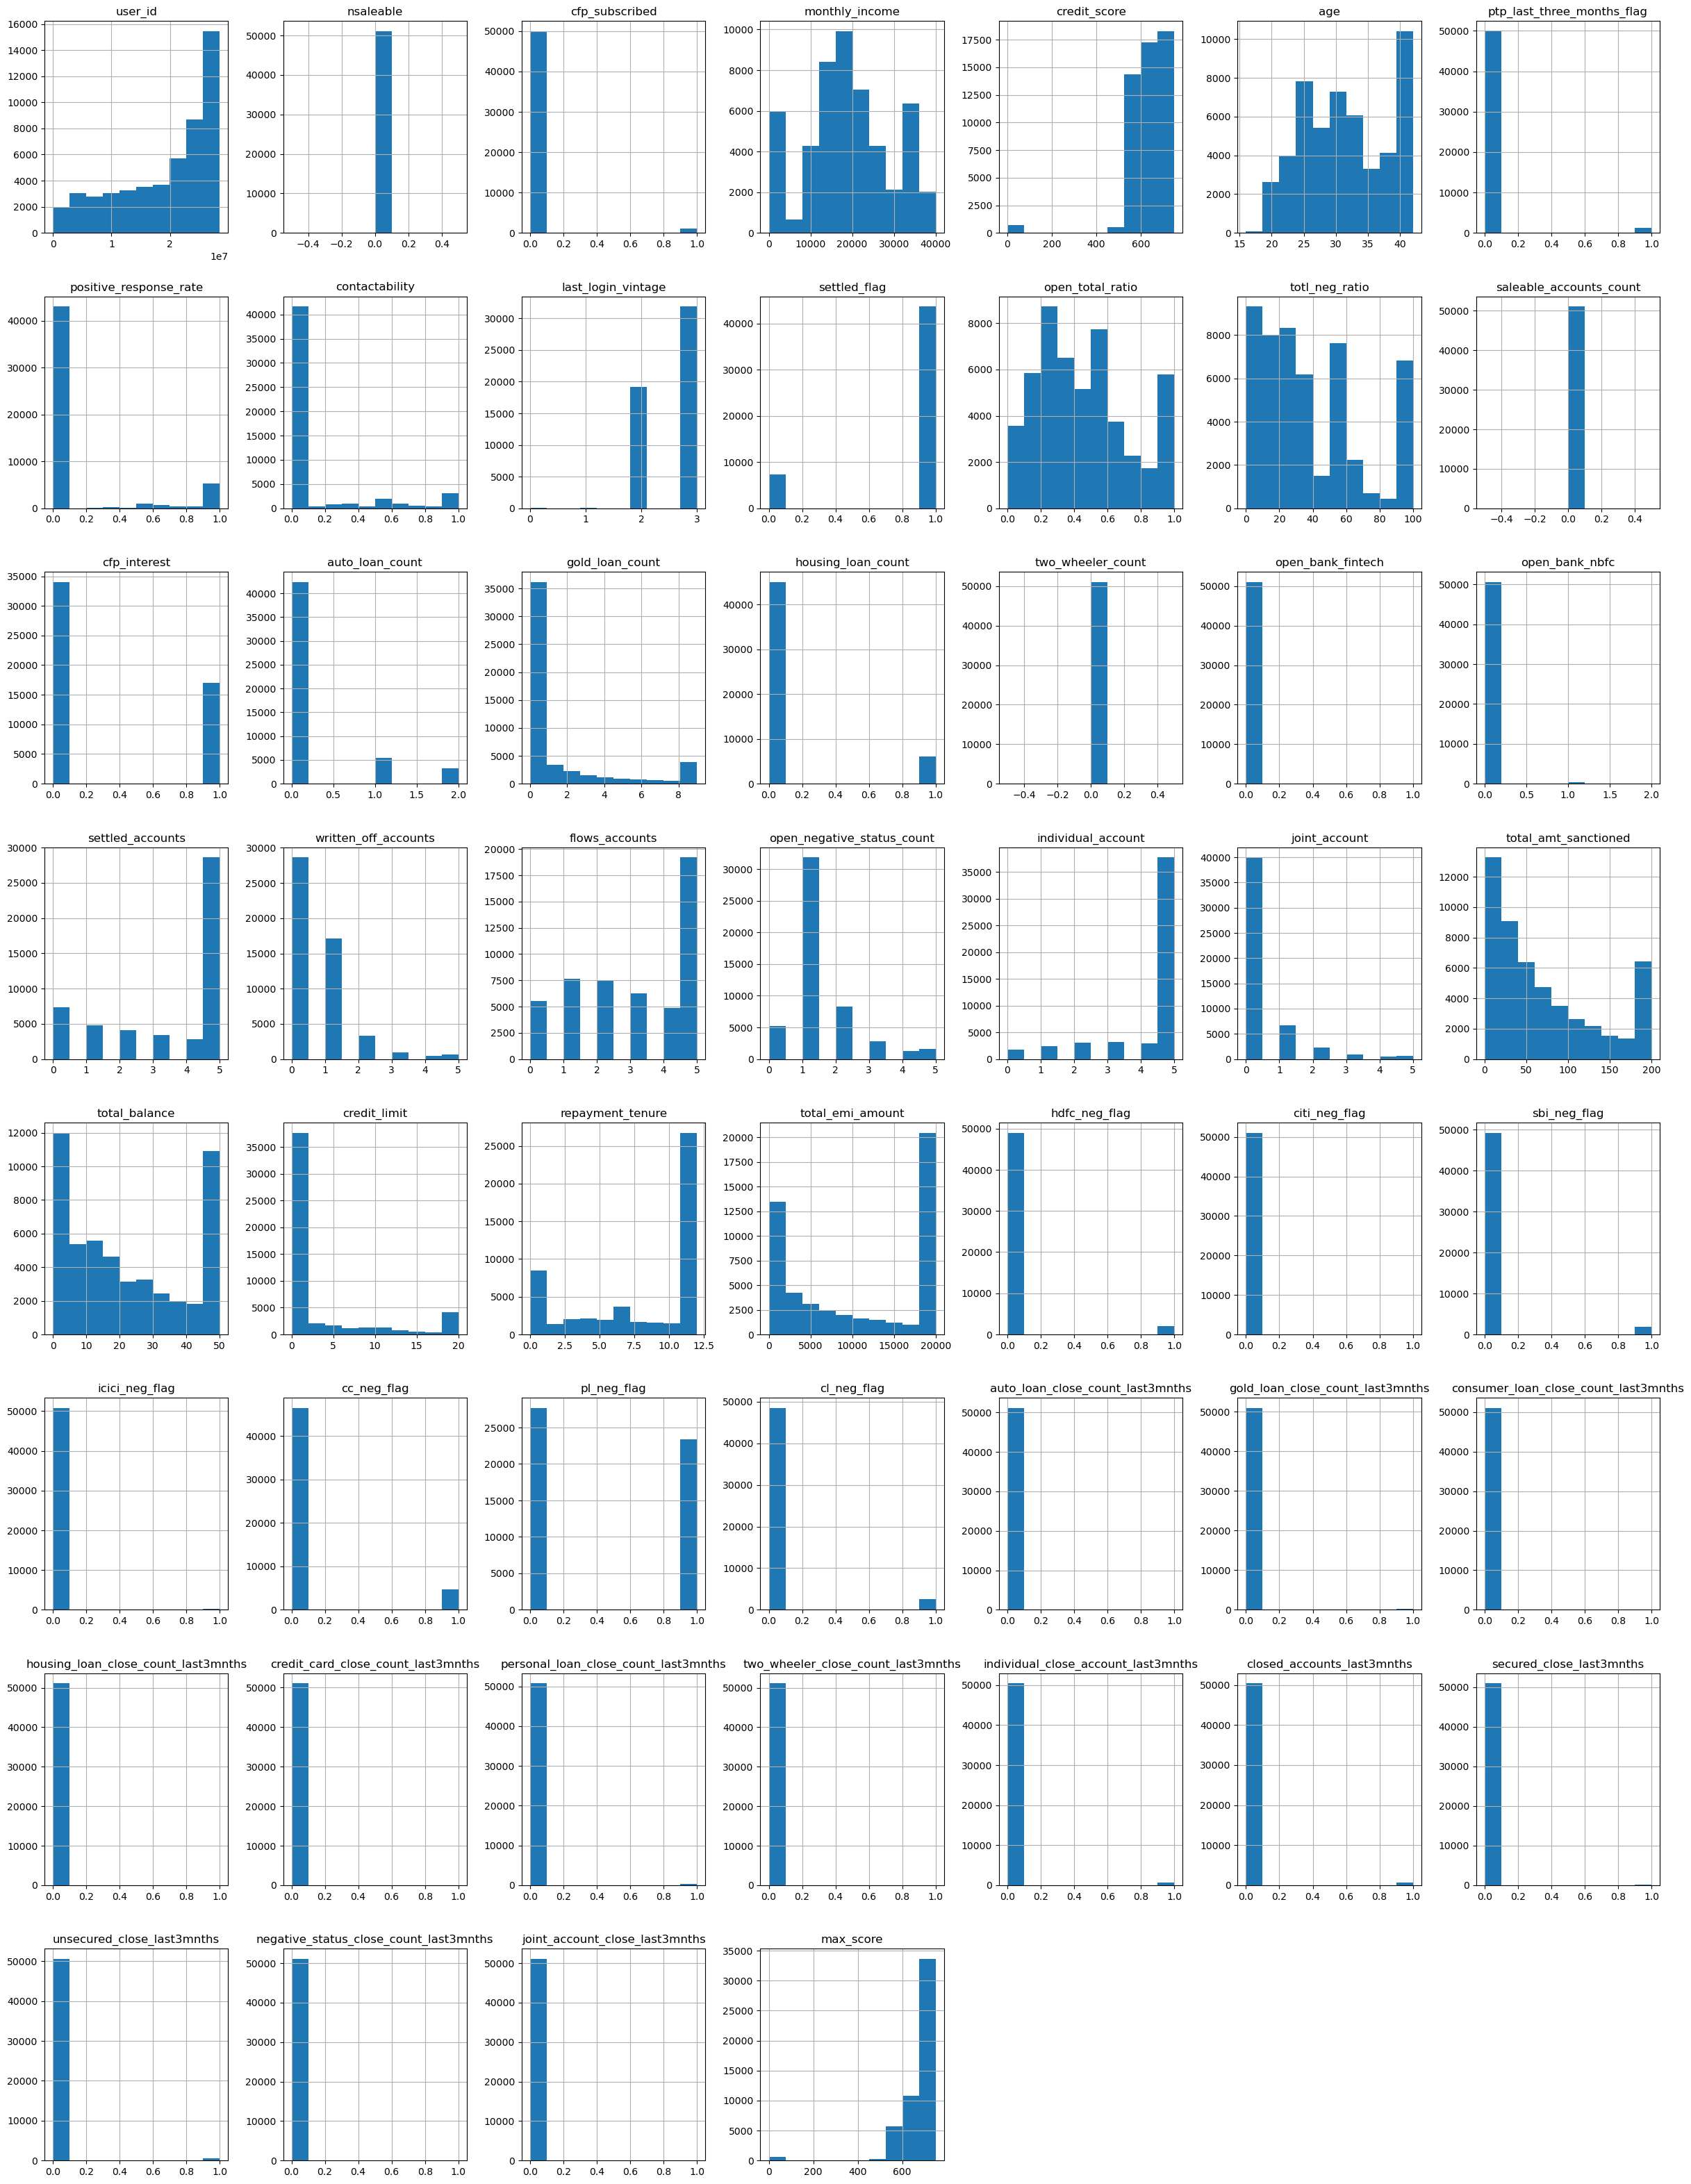

In [35]:
fig = plt.figure(figsize = (30,40))
ax = fig.gca()
cfp_data.hist(ax = ax)
pyplot.show()

In [36]:
exclude=['user_id','cfp_interest','positive_response_rate', 'contactability',
         'ptp_last_three_months_flag','cfp_subscribed', 'ltd', 'nsaleable', 'latest_login_date',
       'salary_account', 'credit_score',
        'pincode', 'marital_status', 'employment_type',
       'first_profile_date', 'latest_profile_date', 'city_band',
       'positive_response_rate', 'email_login_flag', 'unique_days_logged_in_flag',
       'sms_login_flag', 'last_login_vintage', 'negative_status_flag',
       'settled_flag', 'open_total_ratio', 'totl_neg_ratio',
       'saleable_accounts_count', 'cfp_interest', 'auto_loan_count',
       'gold_loan_count', 'housing_loan_count', 'two_wheeler_count',
       'open_bank_fintech', 'open_bank_nbfc', 'settled_accounts',
       'written_off_accounts', 'flows_accounts', 'open_negative_status_count',
       'individual_account', 'joint_account',
       'hdfc_neg_flag', 'citi_neg_flag', 'sbi_neg_flag', 'icici_neg_flag',
       'cc_neg_flag', 'pl_neg_flag', 'cl_neg_flag',
       'auto_loan_close_count_last3mnths', 'gold_loan_close_count_last3mnths',
       'consumer_loan_close_count_last3mnths',
       'housing_loan_close_count_last3mnths',
       'credit_card_close_count_last3mnths',
       'personal_loan_close_count_last3mnths',
       'two_wheeler_close_count_last3mnths',
       'individual_close_account_last3mnths', 'closed_accounts_last3mnths',
       'secured_close_last3mnths', 'unsecured_close_last3mnths',
       'negative_status_close_count_last3mnths',
       'joint_account_close_last3mnths', 'max_score', 'personal_loan_cat',
       'consumer_loan_cat', 'secured_accounts_cat', 'unsecured_accounts_cat'] #,'cfp_subscribed'

In [37]:
numerical_columns=list(cfp_data.select_dtypes(include='number').columns)
for feature in numerical_columns:
    if feature in exclude:
        pass
    else:
        numerical_columns.remove(feature)
print(numerical_columns)

['user_id', 'nsaleable', 'cfp_subscribed', 'credit_score', 'ptp_last_three_months_flag', 'positive_response_rate', 'contactability', 'last_login_vintage', 'settled_flag', 'open_total_ratio', 'totl_neg_ratio', 'saleable_accounts_count', 'cfp_interest', 'auto_loan_count', 'gold_loan_count', 'housing_loan_count', 'two_wheeler_count', 'open_bank_fintech', 'open_bank_nbfc', 'settled_accounts', 'written_off_accounts', 'flows_accounts', 'open_negative_status_count', 'individual_account', 'joint_account', 'total_balance', 'repayment_tenure', 'hdfc_neg_flag', 'citi_neg_flag', 'sbi_neg_flag', 'icici_neg_flag', 'cc_neg_flag', 'pl_neg_flag', 'cl_neg_flag', 'auto_loan_close_count_last3mnths', 'gold_loan_close_count_last3mnths', 'consumer_loan_close_count_last3mnths', 'housing_loan_close_count_last3mnths', 'credit_card_close_count_last3mnths', 'personal_loan_close_count_last3mnths', 'two_wheeler_close_count_last3mnths', 'individual_close_account_last3mnths', 'closed_accounts_last3mnths', 'secured_cl

In [38]:
cfp_data.describe(percentiles=[0.01,0.05,0.10,0.25,0.5,0.75,0.9,0.95,0.99],datetime_is_numeric=True).transpose()

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
user_id,51090.00,19325841.67,8178723.67,1653.00,938911.74,3553750.35,5803663.20,13125410.25,22297933.00,26496621.25,27757910.20,28009970.80,28366399.06,28476002.00
nsaleable,51090.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
cfp_subscribed,51090.00,0.02,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
monthly_income,51090.00,18783.86,10281.18,0.00,0.00,0.00,0.00,13297.80,18157.24,25000.00,33000.00,33000.00,40000.00,40000.00
credit_score,51090.00,627.11,93.40,0.00,0.00,525.00,550.00,575.00,650.00,675.00,700.00,725.00,750.00,750.00
age,51090.00,31.59,6.91,16.00,19.00,21.00,23.00,26.00,31.00,38.00,42.00,42.00,42.00,42.00
ptp_last_three_months_flag,51090.00,0.02,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
positive_response_rate,51090.00,0.14,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00
contactability,51090.00,0.12,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,1.00,1.00,1.00
last_login_vintage,51090.00,2.62,0.49,0.00,2.00,2.00,2.00,2.00,3.00,3.00,3.00,3.00,3.00,3.00


In [39]:
skewww=cfp_data.skew()
for feature in skewww.keys():
    if skewww[feature]<=-3 or skewww[feature]>=3:
        skewww[feature]='(Critical)                '+str(skewww[feature])
    else:
         pass
skewww

C:\Users\Pon kebha.DESKTOP-PI8M9QL\AppData\Local\Temp\ipykernel_15872\152735706.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewww=cfp_data.skew()


user_id                                                                          -0.74
nsaleable                                                                         0.00
cfp_subscribed                             (Critical)                6.625400907229483
monthly_income                                                                   -0.04
credit_score                              (Critical)                -4.016764054704815
age                                                                               0.14
ptp_last_three_months_flag                 (Critical)                6.384921979705123
positive_response_rate                                                            2.08
contactability                                                                    2.25
last_login_vintage                                                               -0.57
settled_flag                                                                     -2.02
open_total_ratio                           

In [40]:
kurt=cfp_data.kurtosis()
for feature in kurt.keys():
    if kurt[feature]<=-10 or kurt[feature]>=10:
        kurt[feature]='(Critical)                '+str(kurt[feature])
    else:
         pass
kurt

C:\Users\Pon kebha.DESKTOP-PI8M9QL\AppData\Local\Temp\ipykernel_15872\846007919.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  kurt=cfp_data.kurtosis()


user_id                                                                          -0.73
nsaleable                                                                         0.00
cfp_subscribed                             (Critical)                41.89757732785556
monthly_income                                                                   -0.40
credit_score                              (Critical)                24.638571421168713
age                                                                              -1.19
ptp_last_three_months_flag                 (Critical)                38.76874635015244
positive_response_rate                                                            2.50
contactability                                                                    3.68
last_login_vintage                                                               -1.37
settled_flag                                                                      2.10
open_total_ratio                           

In [41]:
'''Finding Skewness'''
skewed=[]
def find_skew(data,numerical_columns):
    skew_list={}
    for feature in numerical_columns:
        try:
            try:
                skew_value=(3*(data[feature].mean()-data[feature].median()))/data[feature].std()
                if ((round(skew_value,2)<-3) or (round(skew_value,2)>3)):
                    skew_list[feature]='Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww'
                    skewed.append(feature)
                else:
                    skew_list[feature]=round(skew_value,2)
            except ZeroDivisionError:
                skew_list[feature]='Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww'
                skewed.append(feature)
        except:
            pass
    return skew_list
skew_list=find_skew(cfp_data,numerical_columns)
skewed

['nsaleable', 'saleable_accounts_count', 'two_wheeler_count']

In [42]:
# '''Transforming features - Adjusting for skewness'''
# qt = QuantileTransformer(n_quantiles=51090, output_distribution='normal')
# for i in numerical_columns:
#     if i in exclude:
#         pass
#     else:
#         if i in skewed:
#             array = np.array(cfp_data[i]).reshape(-1, 1)
#             try:
#                 cfp_data[i] = qt.fit_transform(array)
#             except:
#                 pass
# find_skew(cfp_data,numerical_columns)

In [43]:
'''Transforming features - Adjusting for skewness'''
for i in numerical_columns:
    if i in exclude:
        pass
    else:
        try:
            cfp_data[i] =stats.boxcox(array)
        except:
            pass
find_skew(cfp_data,numerical_columns)

{'user_id': -1.09,
 'nsaleable': 'Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww',
 'cfp_subscribed': 0.44,
 'credit_score': -0.74,
 'ptp_last_three_months_flag': 0.46,
 'positive_response_rate': 1.26,
 'contactability': 1.28,
 'last_login_vintage': -2.32,
 'settled_flag': -1.23,
 'open_total_ratio': 0.57,
 'totl_neg_ratio': 0.83,
 'saleable_accounts_count': 'Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww',
 'cfp_interest': 2.12,
 'auto_loan_count': 1.27,
 'gold_loan_count': 1.49,
 'housing_loan_count': 1.09,
 'two_wheeler_count': 'Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww',
 'open_bank_fintech': 0.03,
 'open_bank_nbfc': 0.27,
 'settled_accounts': -2.34,
 'written_off_accounts': 2.03,
 'flows_accounts': 0.12,
 'open_negative_status_count': 1.07,
 'individual_account': -1.55,
 'joint_account': 1.26,
 'total_balance': 0.84,
 'repayment_tenure': -1.86,
 'hdfc_neg_flag': 0.62,
 'citi_neg_flag': 0.05,
 'sbi_neg_flag': 0.58,
 'icici_neg_flag'

In [44]:
cfp_data.head()

,user_id,customer_type,nsaleable,salary_account,cfp_subscribed,monthly_income,credit_score,age,marital_status,employment_type,city_band,ptp_last_three_months_flag,positive_response_rate,contactability,email_login_flag,unique_days_logged_in_flag,sms_login_flag,last_login_vintage,negative_status_flag,settled_flag,open_total_ratio,totl_neg_ratio,saleable_accounts_count,cfp_interest,auto_loan_count,gold_loan_count,housing_loan_count,two_wheeler_count,open_bank_fintech,open_bank_nbfc,settled_accounts,written_off_accounts,flows_accounts,open_negative_status_count,individual_account,joint_account,total_amt_sanctioned,total_balance,credit_limit,repayment_tenure,total_emi_amount,hdfc_neg_flag,citi_neg_flag,sbi_neg_flag,icici_neg_flag,cc_neg_flag,pl_neg_flag,cl_neg_flag,auto_loan_close_count_last3mnths,gold_loan_close_count_last3mnths,consumer_loan_close_count_last3mnths,housing_loan_close_count_last3mnths,credit_card_close_count_last3mnths,personal_loan_close_count_last3mnths,two_wheeler_close_count_last3mnths,individual_close_account_last3mnths,closed_accounts_last3mnths,secured_close_last3mnths,unsecured_close_last3mnths,negative_status_close_count_last3mnths,joint_account_close_last3mnths,max_score,score_track,neg_acc_track,max_dpd_track,open_accounts_cat,closed_accounts_cat,credit_card_cat,personal_loan_cat,consumer_loan_cat,secured_accounts_cat,unsecured_accounts_cat
0,24439938,Red,0,Unknown,1,27268.44,725,34.00,Married,Salaried,Missing/Others,0.00,0.00,1.00,MoreThanOnce,MoreThanThree,MoreThanOnce,3,One,1,0.44,25.00,0,1.00,0.00,0.00,0.00,0.00,0,0,5.00,0.00,4.00,1.00,5.00,0.00,76.00,24.00,0.00,5.00,13097.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,725,Last 6 mths declining,Last 6 mths increasing,Last 6 mths increasing,Four,Five,Zero,MoreThanOne,One,Zero,Nine
1,19588060,Red,0,Unknown,0,17274.09,575,35.00,Single,Self Employed,Delhi/NCR,0.00,0.00,0.00,Zero,MoreThanThree,MoreThanOnce,3,One,1,0.36,12.50,0,0.00,0.00,2.00,0.00,0.00,0,0,5.00,1.00,5.00,1.00,5.00,0.00,44.00,12.00,2.00,12.00,20000.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,725,Last 6 mths declining,Last 6 mths increasing,Last 6 mths increasing,MoreThanFive,MoreThanFive,Two,MoreThanOne,MoreThanTwo,Two,MoreThanTen
2,26851618,Red,0,Unknown,1,25000.00,675,30.00,Married,Salaried,Missing/Others,0.00,0.33,0.43,MoreThanOnce,MoreThanThree,MoreThanOnce,3,One,1,0.50,25.00,0,1.00,0.00,0.00,0.00,0.00,0,0,4.00,0.00,4.00,1.00,5.00,0.00,48.00,14.00,0.00,6.00,13879.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,675,Last 6 mths declining,Last 6 mths increasing,Last 6 mths increasing,Four,Four,Zero,MoreThanOne,Two,Zero,Eight
3,27603975,Red,0,Unknown,0,15000.00,500,22.00,Single,Salaried,Missing/Others,0.00,1.00,0.50,MoreThanOnce,MoreThanThree,MoreThanOnce,3,MoreThanThree,1,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0,0,4.00,1.00,0.00,0.00,5.00,0.00,7.00,0.00,0.00,2.00,2261.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,500,Last 6 mths declining,Last 6 mths increasing,Last 6 mths increasing,Zero,Five,Zero,MoreThanOne,One,Zero,Five
4,16421209,Red,0,Unknown,0,19052.08,675,39.00,Single,Salaried,Missing/Others,0.00,0.00,0.00,Zero,Two,One,3,One,1,0.75,16.67,0,1.00,0.00,0.00,0.00,0.00,0,0,3.00,0.00,5.00,1.00,5.00,1.00,78.00,14.00,0.00,12.00,7342.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,725,Last 6 mths declining,Last 6 mths increasing,Last 6 mths increasing,MoreThanFive,Two,Zero,Zero,MoreThanTwo,Two,Six


In [45]:
'''Removing too skewed'''
cfp_data.drop(['nsaleable','saleable_accounts_count','two_wheeler_count','customer_type'],axis=1,inplace=True)
find_skew(cfp_data,numerical_columns)

{'user_id': -1.09,
 'cfp_subscribed': 0.44,
 'credit_score': -0.74,
 'ptp_last_three_months_flag': 0.46,
 'positive_response_rate': 1.26,
 'contactability': 1.28,
 'last_login_vintage': -2.32,
 'settled_flag': -1.23,
 'open_total_ratio': 0.57,
 'totl_neg_ratio': 0.83,
 'cfp_interest': 2.12,
 'auto_loan_count': 1.27,
 'gold_loan_count': 1.49,
 'housing_loan_count': 1.09,
 'open_bank_fintech': 0.03,
 'open_bank_nbfc': 0.27,
 'settled_accounts': -2.34,
 'written_off_accounts': 2.03,
 'flows_accounts': 0.12,
 'open_negative_status_count': 1.07,
 'individual_account': -1.55,
 'joint_account': 1.26,
 'total_balance': 0.84,
 'repayment_tenure': -1.86,
 'hdfc_neg_flag': 0.62,
 'citi_neg_flag': 0.05,
 'sbi_neg_flag': 0.58,
 'icici_neg_flag': 0.24,
 'cc_neg_flag': 0.95,
 'pl_neg_flag': 2.76,
 'cl_neg_flag': 0.7,
 'auto_loan_close_count_last3mnths': 0.03,
 'gold_loan_close_count_last3mnths': 0.17,
 'consumer_loan_close_count_last3mnths': 0.11,
 'housing_loan_close_count_last3mnths': 0.02,
 'credi

### Pickling Data

In [46]:
# joblib.dump(cfp_data, 'cfp_transformed_data_Green.pkl')
joblib.dump(cfp_data, 'cfp_transformed_data_Red.pkl')
# joblib.dump(cfp_data, 'cfp_transformed_data_Red_ltd.pkl')
# joblib.dump(cfp_data, 'cfp_transformed_data_Green_ltd.pkl')

['cfp_transformed_data_Red.pkl']

In [47]:
# cfp_clean_data=joblib.load('cfp_transformed_data_Green.pkl')
cfp_clean_data=joblib.load('cfp_transformed_data_Red.pkl')
# cfp_clean_data=joblib.load('cfp_transformed_data_Red_ltd.pkl')
# cfp_clean_data=joblib.load('cfp_transformed_data_Green_ltd.pkl')

In [48]:
cfp_clean_data.head()

,user_id,salary_account,cfp_subscribed,monthly_income,credit_score,age,marital_status,employment_type,city_band,ptp_last_three_months_flag,positive_response_rate,contactability,email_login_flag,unique_days_logged_in_flag,sms_login_flag,last_login_vintage,negative_status_flag,settled_flag,open_total_ratio,totl_neg_ratio,cfp_interest,auto_loan_count,gold_loan_count,housing_loan_count,open_bank_fintech,open_bank_nbfc,settled_accounts,written_off_accounts,flows_accounts,open_negative_status_count,individual_account,joint_account,total_amt_sanctioned,total_balance,credit_limit,repayment_tenure,total_emi_amount,hdfc_neg_flag,citi_neg_flag,sbi_neg_flag,icici_neg_flag,cc_neg_flag,pl_neg_flag,cl_neg_flag,auto_loan_close_count_last3mnths,gold_loan_close_count_last3mnths,consumer_loan_close_count_last3mnths,housing_loan_close_count_last3mnths,credit_card_close_count_last3mnths,personal_loan_close_count_last3mnths,two_wheeler_close_count_last3mnths,individual_close_account_last3mnths,closed_accounts_last3mnths,secured_close_last3mnths,unsecured_close_last3mnths,negative_status_close_count_last3mnths,joint_account_close_last3mnths,max_score,score_track,neg_acc_track,max_dpd_track,open_accounts_cat,closed_accounts_cat,credit_card_cat,personal_loan_cat,consumer_loan_cat,secured_accounts_cat,unsecured_accounts_cat
0,24439938,Unknown,1,27268.44,725,34.00,Married,Salaried,Missing/Others,0.00,0.00,1.00,MoreThanOnce,MoreThanThree,MoreThanOnce,3,One,1,0.44,25.00,1.00,0.00,0.00,0.00,0,0,5.00,0.00,4.00,1.00,5.00,0.00,76.00,24.00,0.00,5.00,13097.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,725,Last 6 mths declining,Last 6 mths increasing,Last 6 mths increasing,Four,Five,Zero,MoreThanOne,One,Zero,Nine
1,19588060,Unknown,0,17274.09,575,35.00,Single,Self Employed,Delhi/NCR,0.00,0.00,0.00,Zero,MoreThanThree,MoreThanOnce,3,One,1,0.36,12.50,0.00,0.00,2.00,0.00,0,0,5.00,1.00,5.00,1.00,5.00,0.00,44.00,12.00,2.00,12.00,20000.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,725,Last 6 mths declining,Last 6 mths increasing,Last 6 mths increasing,MoreThanFive,MoreThanFive,Two,MoreThanOne,MoreThanTwo,Two,MoreThanTen
2,26851618,Unknown,1,25000.00,675,30.00,Married,Salaried,Missing/Others,0.00,0.33,0.43,MoreThanOnce,MoreThanThree,MoreThanOnce,3,One,1,0.50,25.00,1.00,0.00,0.00,0.00,0,0,4.00,0.00,4.00,1.00,5.00,0.00,48.00,14.00,0.00,6.00,13879.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,675,Last 6 mths declining,Last 6 mths increasing,Last 6 mths increasing,Four,Four,Zero,MoreThanOne,Two,Zero,Eight
3,27603975,Unknown,0,15000.00,500,22.00,Single,Salaried,Missing/Others,0.00,1.00,0.50,MoreThanOnce,MoreThanThree,MoreThanOnce,3,MoreThanThree,1,0.00,0.00,0.00,0.00,0.00,0.00,0,0,4.00,1.00,0.00,0.00,5.00,0.00,7.00,0.00,0.00,2.00,2261.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,500,Last 6 mths declining,Last 6 mths increasing,Last 6 mths increasing,Zero,Five,Zero,MoreThanOne,One,Zero,Five
4,16421209,Unknown,0,19052.08,675,39.00,Single,Salaried,Missing/Others,0.00,0.00,0.00,Zero,Two,One,3,One,1,0.75,16.67,1.00,0.00,0.00,0.00,0,0,3.00,0.00,5.00,1.00,5.00,1.00,78.00,14.00,0.00,12.00,7342.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,725,Last 6 mths declining,Last 6 mths increasing,Last 6 mths increasing,MoreThanFive,Two,Zero,Zero,MoreThanTwo,Two,Six


### Removing Unwanted Columns

In [49]:
user_ids=pd.concat([cfp_clean_data['user_id'].reset_index(drop = True)], axis = 1)
cfp_clean_data=cfp_clean_data.drop(['user_id'],axis=1)

In [50]:
user_ids.head()

,user_id
0,24439938
1,19588060
2,26851618
3,27603975
4,16421209


### Segregate Columns for Encoding and Scaling

In [51]:
exemption_features=['cfp_subscribed']
id_columns=['user_id']

In [52]:
categorical_features=list(cfp_clean_data.select_dtypes(exclude='number').columns)
categorical_features

['salary_account',
 'marital_status',
 'employment_type',
 'city_band',
 'email_login_flag',
 'unique_days_logged_in_flag',
 'sms_login_flag',
 'negative_status_flag',
 'score_track',
 'neg_acc_track',
 'max_dpd_track',
 'open_accounts_cat',
 'closed_accounts_cat',
 'credit_card_cat',
 'personal_loan_cat',
 'consumer_loan_cat',
 'secured_accounts_cat',
 'unsecured_accounts_cat']

In [53]:
numeric_features=list(cfp_clean_data.select_dtypes(include='number').columns)
numeric_features
flag_features=[]
for feature in exemption_features:
    numeric_features.remove(feature)
for feature in exclude:
    if feature in numeric_features:
        flag_features.append(feature)
        numeric_features.remove(feature)
    

In [54]:
'''Encoding categorical features with dummies'''
dummies = pd.get_dummies(data = cfp_clean_data[categorical_features], drop_first=False)
# dummies.drop(['salary_account_Other'],axis=1,inplace=True)
# dummies.drop(['salary_account_CANARA'],axis=1,inplace=True) #Only for green ltd
dummies.columns

Index(['salary_account_I receive by cash', 'salary_account_Other',
       'salary_account_Private', 'salary_account_Public',
       'salary_account_Unknown', 'marital_status_Married',
       'marital_status_Single', 'employment_type_Salaried',
       'employment_type_Self Employed', 'city_band_Bangalore',
       'city_band_Chennai', 'city_band_Delhi/NCR', 'city_band_Hyderabad',
       'city_band_Kolkata', 'city_band_Missing/Others', 'city_band_Mumbai',
       'city_band_Pune', 'email_login_flag_MoreThanOnce',
       'email_login_flag_One', 'email_login_flag_Zero',
       'unique_days_logged_in_flag_MoreThanThree',
       'unique_days_logged_in_flag_One', 'unique_days_logged_in_flag_Three',
       'unique_days_logged_in_flag_Two', 'sms_login_flag_MoreThanOnce',
       'sms_login_flag_One', 'sms_login_flag_Zero',
       'negative_status_flag_MoreThanThree', 'negative_status_flag_One',
       'negative_status_flag_Three', 'negative_status_flag_Two',
       'score_track_Last 3 mths Score i

In [55]:
'''Scaling numeric features'''
standard_scalar = StandardScaler(with_mean=True,with_std=True)
standard_scalar.fit(cfp_clean_data[numeric_features])
numeric_data_scaled = standard_scalar.transform(cfp_clean_data[numeric_features])
numeric_data_scaled = pd.DataFrame(numeric_data_scaled,columns=numeric_features)
numeric_data_scaled.head()

,monthly_income,age,total_amt_sanctioned,total_balance,credit_limit,repayment_tenure,total_emi_amount
0,0.83,0.35,0.08,0.11,-0.50,-0.68,0.28
1,-0.15,0.49,-0.42,-0.56,-0.16,0.84,1.09
2,0.60,-0.23,-0.36,-0.45,-0.50,-0.46,0.37
3,-0.37,-1.39,-0.99,-1.22,-0.50,-1.33,-0.99
4,0.03,1.07,0.11,-0.45,-0.50,0.84,-0.40


In [56]:
'''Concatenating all features'''
processed_dataset = pd.concat([user_ids[id_columns].reset_index(drop = True), 
                               numeric_data_scaled.reset_index(drop = True),
                               cfp_clean_data[flag_features].reset_index(drop = True),
                               dummies.reset_index(drop = True),
                              cfp_clean_data[exemption_features].reset_index(drop = True)
                              ], axis=1)
processed_dataset.shape

(51090, 133)

In [57]:
'''Replace Infinite'''
processed_dataset = processed_dataset.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
processed_dataset.shape

(51090, 133)

In [58]:
'''Eliminating worst features to increase binding'''
'''red'''
# worst_features=['auto_loan_close_count_last3mnths',
#  'cc_neg_flag',
#  'citi_neg_flag',
#  'cl_neg_flag',
#  'consumer_loan_close_count_last3mnths',
#  'credit_card_close_count_last3mnths',
#  'gold_loan_close_count_last3mnths',
#  'hdfc_neg_flag',
#  'housing_loan_close_count_last3mnths',
#  'icici_neg_flag',
#  'joint_account_close_last3mnths',
#  'max_dpd_on_m12',
#  'max_dpd_on_m3',
#  'max_dpd_on_m6',
#  'max_dpd_on_m9',
#  'neg_acc_on_m12',
#  'neg_acc_on_m3',
#  'neg_acc_on_m6',
#  'neg_acc_on_m9',
#  'negative_status_close_count_last3mnths',
#  'negative_status_flag_One',
#  'nsaleable',
#  'open_negative_status_count',
#  'pl_neg_flag',
#  'saleable_accounts_count',
#  'sbi_neg_flag',
#  'secured_close_last3mnths',
#  'totl_neg_ratio',
#  'two_wheeler_close_count_last3mnths',
#  'two_wheeler_count',
#  'written_off_accounts']
# best_features=['age','auto_loan_count','cc_neg_flag','cfp_interest','city_band_Chennai','city_band_Delhi/NCR','city_band_Hyderabad','city_band_Kolkata','city_band_Missing/Others','city_band_Mumbai','city_band_Pune','cl_neg_flag','closed_accounts','closed_accounts_last3mnths','consumer_loan_count','contactability','credit_card_count','credit_limit','credit_score','email_login_flag_One','email_login_flag_Zero','employment_type_Self Employed','flows_accounts','gold_loan_count','hdfc_neg_flag','housing_loan_count','icici_neg_flag','individual_account','individual_close_account_last3mnths','joint_account','last_login_vintage_M1toM2','last_login_vintage_M3toM6','last_login_vintage_M7toM12','marital_status_Single','max_dpd_on_m3','max_score','monthly_income','neg_acc_on_m12','neg_acc_on_m3','neg_acc_on_m6','neg_acc_on_m9','negative_status_flag_One','negative_status_flag_Three','negative_status_flag_Two','nsaleable','open_accounts','open_negative_status_count','open_total_ratio','personal_loan_count','pl_neg_flag','positive_response_rate','ptp_last_three_months_flag','repayment_tenure','salary_account_AXIS','salary_account_CITI','salary_account_HDFC','salary_account_HDFC Bank','salary_account_I receive by cash','salary_account_ICICI','salary_account_JAMMU & KASHMIR','salary_account_SBI','salary_account_Unknown','salary_account_YESBANK','salary_account_andhra bank','salary_account_otherBank','saleable_accounts_count','sbi_neg_flag','score_on_m12','score_on_m3','score_on_m6','score_on_m9','secured','settled_accounts','settled_flag','sms_login_flag_One','sms_login_flag_Zero','total_amt_sanctioned','total_balance','total_emi_amount','totl_neg_ratio','unique_days_logged_in_flag_One','unique_days_logged_in_flag_Three','unique_days_logged_in_flag_Two','unsecured','unsecured_close_last3mnths','written_off_accounts']
'''green'''
# worst_features=['two_wheeler_count', 'citi_neg_flag', 'auto_loan_close_count_last3mnths', 'gold_loan_close_count_last3mnths', 'consumer_loan_close_count_last3mnths', 'housing_loan_close_count_last3mnths', 'credit_card_close_count_last3mnths', 'two_wheeler_close_count_last3mnths', 'secured_close_last3mnths', 'negative_status_close_count_last3mnths', 'joint_account_close_last3mnths', 'max_dpd_on_m9', 'max_dpd_on_m12', 'max_dpd_on_m6','nsaleable', 'monthly_income', 'age', 'positive_response_rate', 'settled_flag', 'totl_neg_ratio', 'saleable_accounts_count', 'gold_loan_count', 'housing_loan_count', 'credit_card_count', 'open_accounts', 'closed_accounts', 'settled_accounts', 'written_off_accounts', 'open_negative_status_count', 'joint_account', 'total_emi_amount', 'hdfc_neg_flag', 'sbi_neg_flag', 'icici_neg_flag', 'cc_neg_flag', 'pl_neg_flag', 'cl_neg_flag', 'individual_close_account_last3mnths', 'closed_accounts_last3mnths', 'score_on_m9', 'score_on_m12', 'score_on_m6', 'neg_acc_on_m9', 'neg_acc_on_m3', 'neg_acc_on_m12', 'neg_acc_on_m6', 'max_dpd_on_m3', 'salary_account_ACCOUNT', 'salary_account_ACCOUNT TRANSFER', 'salary_account_ALLAHABAD BANK', 'salary_account_ANDHRA', 'salary_account_ANDHRA BANK', 'salary_account_ANDRA BANK', 'salary_account_ANNAI SAI MAGAR BANK', 'salary_account_AU SMALL FINANCE', 'salary_account_AXIS', 'salary_account_Allahabad BAnk', 'salary_account_Allahabad bank', 'salary_account_Andhar Bank', 'salary_account_Andhara bank', 'salary_account_AndhraBank', 'salary_account_Axis', 'salary_account_BANK OF BARODA', 'salary_account_BANK OF INDIA', 'salary_account_BANK OF MAHARASHTRA', 'salary_account_BANK OF MAHARASTRA', 'salary_account_BANK OF MAHARASTRA/BANK OF BARODA', 'salary_account_BANK of BARODA', 'salary_account_BOB', 'salary_account_BOI', 'salary_account_BOM', 'salary_account_BY CASH', 'salary_account_Bandhan bank', 'salary_account_Bank of Baroda', 'salary_account_Bank of India', 'salary_account_Bank of Maharashtra', 'salary_account_Bank of baroda', 'salary_account_Bank of india', 'salary_account_Bank of maharashtra', 'salary_account_Bank or maharashtra', 'salary_account_CANA', 'salary_account_CANARA BANK', 'salary_account_CASH', 'salary_account_CBI', 'salary_account_CBQ', 'salary_account_CENTRAL BANK OF INDIA', 'salary_account_CITI', 'salary_account_CITI UNION BANK', 'salary_account_CITY UNION', 'salary_account_CORPORATIOM', 'salary_account_CORPORATION', 'salary_account_CORPORATION BANK', 'salary_account_COSMO BANK', 'salary_account_COSMOS BANK', 'salary_account_Canara', 'salary_account_Canara Bank', 'salary_account_Canara bank', 'salary_account_Cash', 'salary_account_Catholic Syrian bank', 'salary_account_Central Bank of India', 'salary_account_Central bank of india', 'salary_account_Co-operative Bank', 'salary_account_Corp Bank', 'salary_account_Corporation Bank', 'salary_account_Corporation bank', 'salary_account_DENA', 'salary_account_DEUTSCHE BANK', 'salary_account_DUTCH BANK', 'salary_account_Dena bank', 'salary_account_Deutsche Bank', 'salary_account_Dhanalaxmi Bank', 'salary_account_Direct Credit in union bank of india', 'salary_account_FEDERAL BANK', 'salary_account_FORD', 'salary_account_Federal Bank', 'salary_account_GDCC Bank Pvt. Ltd', 'salary_account_HAND CASH', 'salary_account_HDFC Bank', 'salary_account_HINDUSTHAN', 'salary_account_HSBC', 'salary_account_HSBC Electronic Data Processing Pvt Ltd', 'salary_account_HSBC bank', 'salary_account_Hsbc', 'salary_account_I receive by cash', 'salary_account_I receive by cheque', 'salary_account_I received in cash', 'salary_account_ICICI', 'salary_account_IDBI', 'salary_account_IDBI BANK', 'salary_account_IDBI BANK LTD.', 'salary_account_IDBI Bank', 'salary_account_IDFC', 'salary_account_INDIAN', 'salary_account_INDIAN BANK', 'salary_account_INDIAN OVERSEAS', 'salary_account_INDUSIND', 'salary_account_INDUSIND BANK', 'salary_account_ING', 'salary_account_ING Vysya', 'salary_account_ING is Now Kotak', 'salary_account_IOB', 'salary_account_IOB BANK', 'salary_account_IOB Bank', 'salary_account_Idbi', 'salary_account_Idbi bank', 'salary_account_Indian Bank', 'salary_account_Indian bank', 'salary_account_Indian overseas bank', 'salary_account_Indian oversies bank', 'salary_account_Indianbank', 'salary_account_Indusind', 'salary_account_Indusind Bank', 'salary_account_Indusind bank', 'salary_account_Indusind bank ltd', 'salary_account_Ing vysya bank', 'salary_account_JANATA SAHAKARI BANK', 'salary_account_Janata sahakari bank', 'salary_account_KALYAN JANATA SAHAKARI', 'salary_account_KARNATAKA BANK', 'salary_account_KARUR VYSYA', 'salary_account_KARYR VYSYA BANK', 'salary_account_KMB', 'salary_account_KOTAK', 'salary_account_KOTAK MAHINDAR BANK', 'salary_account_KOTAK MAHINDRA', 'salary_account_KOTAK MAHINDRA BANK', 'salary_account_KOTAK MAHINDRA BANL LTD', 'salary_account_KOTAK MAHINDRA bank', 'salary_account_KVB', 'salary_account_Karnataka bank Ltd', 'salary_account_Karur Vysya Bank', 'salary_account_Kotak', 'salary_account_Kotak Mahendra bank', 'salary_account_Kotak Mahindra', 'salary_account_Kotak Mahindra Bank', 'salary_account_Kotak Mahindra bank', 'salary_account_Kotak bank', 'salary_account_Kotak mahendra bank', 'salary_account_Kotak mahindra', 'salary_account_Kotak mahindra bank', 'salary_account_LVB', 'salary_account_Mahindra kotak', 'salary_account_NRI', 'salary_account_OBC', 'salary_account_ORIENTAL BANK OF COMMERCE', 'salary_account_Oriental Bank of Commerce', 'salary_account_PMC bank', 'salary_account_PNB', 'salary_account_POSTOFFICE      SALARY ACCOUNT', 'salary_account_PUNJAB NATIONAL BANK', 'salary_account_Punjab National Bank', 'salary_account_Punjab national bank', 'salary_account_RBL', 'salary_account_RBL BANK', 'salary_account_RBL Bank', 'salary_account_Ratnakar Bank', 'salary_account_Ratnakar Bank Limited', 'salary_account_SBBJ', 'salary_account_SBH', 'salary_account_SBI', 'salary_account_SBI GROUP', 'salary_account_SBM', 'salary_account_SBP', 'salary_account_SBT', 'salary_account_SCB', 'salary_account_SOUTH INDIA BANK', 'salary_account_SOUTH INDIAN', 'salary_account_SOUTH INDIAN BANK', 'salary_account_STANDARD', 'salary_account_STANDARD CHARTED', 'salary_account_STANDARD CHARTED BANK', 'salary_account_STANDARD CHARTERED', 'salary_account_STANDARD CHARTERED BANK', 'salary_account_STANDRED CHARTRED BANK', 'salary_account_STATE BANK OF BIKANER & JAIPUR', 'salary_account_STATE BANK OF HYDERABAD', 'salary_account_STATE BANK OF MYSORE', 'salary_account_STATEBANK OF TRAVANCORE', 'salary_account_STB', 'salary_account_SYNDICATE', 'salary_account_SYNDICATE BANK', 'salary_account_Saraswat bank', 'salary_account_Sarswath cooperative bank', 'salary_account_Sbbj', 'salary_account_South Indian Bank', 'salary_account_South Indian bank', 'salary_account_Standard Charted Bank', 'salary_account_Standard Charterd Bank', 'salary_account_Standard Chartered', 'salary_account_Standard Chartered Bank', 'salary_account_Standard Chartered bank', 'salary_account_Standard Chattered', 'salary_account_Standard chartered', 'salary_account_Standard chartered bank', 'salary_account_Standart chartered', 'salary_account_Standered charted bank', 'salary_account_State Bank Of Tranvakoor', 'salary_account_State Bank of Hyderabad', 'salary_account_State bank of Hyderabad', 'salary_account_State bank of hyderabad', 'salary_account_State bank of mysore', 'salary_account_Syndicate Bank', 'salary_account_Syndicate bank', 'salary_account_Syndicatebank', 'salary_account_TAMILNAD MERCANTILE BANK', 'salary_account_THE FEDERAL BANK LTD', 'salary_account_THROUGH BANK ACCOUNT', 'salary_account_TMB', 'salary_account_The Ahmedabad District Cooperative bank Ltd', 'salary_account_The Saraswat co-operative Bank', 'salary_account_Transfer through UAE', 'salary_account_UBI', 'salary_account_UCO', 'salary_account_UCO BANK', 'salary_account_UNION', 'salary_account_UNION BANK OF INDIA', 'salary_account_UNITED BANK OF INDIA', 'salary_account_Ubi', 'salary_account_Uco bank', 'salary_account_Union Bank of India', 'salary_account_Union bank', 'salary_account_Union bank of india', 'salary_account_Unknown', 'salary_account_Uttar banga kheyriya gramin bank', 'salary_account_VIJAYA BANK', 'salary_account_Vijaya Bank', 'salary_account_Vijaya bank', 'salary_account_YES', 'salary_account_YES BANK', 'salary_account_YESBANK', 'salary_account_Yes', 'salary_account_Yes Bank', 'salary_account_Yes bank', 'salary_account_andhra bank', 'salary_account_andhrabank', 'salary_account_axis bank', 'salary_account_bank', 'salary_account_bank of baroda', 'salary_account_bank of india', 'salary_account_bank of maharashtra', 'salary_account_bob', 'salary_account_boi', 'salary_account_bom', 'salary_account_by cash', 'salary_account_canara', 'salary_account_canara bank', 'salary_account_cash', 'salary_account_cbi', 'salary_account_central bank of india', 'salary_account_citibank', 'salary_account_city union bank', 'salary_account_co operative bank', 'salary_account_co-operative', 'salary_account_corparation bank', 'salary_account_corporation', 'salary_account_corporation Bank', 'salary_account_corporation bank', 'salary_account_creditted to bank', 'salary_account_deutsche bank', 'salary_account_dhanalakshmi bank', 'salary_account_federal bank', 'salary_account_hdfc', 'salary_account_hsbc', 'salary_account_idbi', 'salary_account_idbi bank', 'salary_account_img', 'salary_account_indian', 'salary_account_indian bank', 'salary_account_indian overseas bank', 'salary_account_indusind', 'salary_account_indusind bank', 'salary_account_indusinda bank', 'salary_account_indusinf', 'salary_account_ing', 'salary_account_ing vysa', 'salary_account_iob', 'salary_account_karur vysya bank', 'salary_account_kotak', 'salary_account_kotak BANK', 'salary_account_kotak Mahindra Bank', 'salary_account_kotak bank', 'salary_account_kotak mahindra', 'salary_account_kotak mahindra bank', 'salary_account_lakshmi vilas bank', 'salary_account_neft', 'salary_account_obc', 'salary_account_oriental bank of commerce', 'salary_account_other', 'salary_account_otherBank', 'salary_account_others', 'salary_account_pnb', 'salary_account_punjab national bank', 'salary_account_receiveByCashOrCheque', 'salary_account_saraswath co-operativa bank', 'salary_account_sbbj', 'salary_account_sbh', 'salary_account_sbi', 'salary_account_sbm', 'salary_account_south Indian Bank', 'salary_account_standard Charatered', 'salary_account_standard charted', 'salary_account_standard charted bank', 'salary_account_standard chartered', 'salary_account_standard chartered bank', 'salary_account_standard chatered', 'salary_account_standerd charted', 'salary_account_state Bank of travancore', 'salary_account_state bank of hyderabad', 'salary_account_state bank of mysore', 'salary_account_state bank of patila', 'salary_account_state bank of travancore', 'salary_account_statebankofhyderabad', 'salary_account_suh', 'salary_account_syndicate', 'salary_account_syndicate bank', 'salary_account_through bank', 'salary_account_ubi', 'salary_account_union bank of india', 'salary_account_yes bank', 'salary_account_yesbank', 'marital_status_Single', 'employment_type_Self Employed', 'city_band_Chennai', 'city_band_Kolkata', 'city_band_Pune', 'email_login_flag_One', 'unique_days_logged_in_flag_Three', 'negative_status_flag_One']
# try:
#     for feature in worst_features:
#         processed_dataset.drop([feature],axis=1,inplace=True)
# except:
#     pass
# processed_dataset=processed_dataset[best_features]
# processed_dataset.head()


'green'

In [59]:
list(processed_dataset.columns)

['user_id',
 'monthly_income',
 'age',
 'total_amt_sanctioned',
 'total_balance',
 'credit_limit',
 'repayment_tenure',
 'total_emi_amount',
 'cfp_interest',
 'positive_response_rate',
 'contactability',
 'ptp_last_three_months_flag',
 'credit_score',
 'last_login_vintage',
 'settled_flag',
 'open_total_ratio',
 'totl_neg_ratio',
 'auto_loan_count',
 'gold_loan_count',
 'housing_loan_count',
 'open_bank_fintech',
 'open_bank_nbfc',
 'settled_accounts',
 'written_off_accounts',
 'flows_accounts',
 'open_negative_status_count',
 'individual_account',
 'joint_account',
 'hdfc_neg_flag',
 'citi_neg_flag',
 'sbi_neg_flag',
 'icici_neg_flag',
 'cc_neg_flag',
 'pl_neg_flag',
 'cl_neg_flag',
 'auto_loan_close_count_last3mnths',
 'gold_loan_close_count_last3mnths',
 'consumer_loan_close_count_last3mnths',
 'housing_loan_close_count_last3mnths',
 'credit_card_close_count_last3mnths',
 'personal_loan_close_count_last3mnths',
 'two_wheeler_close_count_last3mnths',
 'individual_close_account_last3m

In [60]:
processed_dataset.isnull().sum()

user_id                                     0
monthly_income                              0
age                                         0
total_amt_sanctioned                        0
total_balance                               0
credit_limit                                0
repayment_tenure                            0
total_emi_amount                            0
cfp_interest                                0
positive_response_rate                      0
contactability                              0
ptp_last_three_months_flag                  0
credit_score                                0
last_login_vintage                          0
settled_flag                                0
open_total_ratio                            0
totl_neg_ratio                              0
auto_loan_count                             0
gold_loan_count                             0
housing_loan_count                          0
open_bank_fintech                           0
open_bank_nbfc                    

In [61]:
# processed_dataset.last_login_vintage_M1toM2.value_counts()

In [62]:
# processed_dataset.loc[processed_dataset['cfp_subscribed'] == 1].last_login_vintage_M1toM2.value_counts()

In [63]:
# processed_dataset.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

## Train Test Split

In [66]:
'''  Preparing test and train data '''
data=processed_dataset[['user_id','cfp_subscribed','monthly_income',	'contactability',	'positive_response_rate',	'total_amt_sanctioned',	'open_total_ratio',	'totl_neg_ratio',	'age',	'total_balance',	'total_emi_amount',	'max_score',	'credit_score',	'cfp_interest',	'unique_days_logged_in_flag_MoreThanThree',	'credit_limit',	'last_login_vintage',	'ptp_last_three_months_flag',	'gold_loan_count',	'repayment_tenure',	'sms_login_flag_MoreThanOnce',	'written_off_accounts',	'joint_account',	'individual_account',	'email_login_flag_MoreThanOnce',	'sms_login_flag_Zero',	'flows_accounts',	'email_login_flag_Zero',	'open_negative_status_count',	'settled_accounts',	'score_track_Last 3 mths Score improving',	'city_band_Delhi/NCR',	'city_band_Chennai',	'marital_status_Married',	'secured_accounts_cat_Three',	'consumer_loan_cat_MoreThanTwo',	'credit_card_cat_One',	'auto_loan_count',	'city_band_Bangalore',	'unsecured_accounts_cat_MoreThanTen',	'unsecured_accounts_cat_Seven',	'credit_card_cat_Two',	'city_band_Hyderabad',	'score_track_Last 6 mths declining',	'personal_loan_cat_Zero',	'consumer_loan_cat_Two',	'open_accounts_cat_Two',	'salary_account_Unknown',	'unsecured_accounts_cat_Two',	'unsecured_accounts_cat_Six',	'unsecured_accounts_cat_Ten',	'credit_card_cat_MoreThanFive',	'open_bank_nbfc']]
data.drop_duplicates(inplace = True)

'''  Splitting test and train data '''
X = data.loc[:,data.columns != 'cfp_subscribed']
y = data['cfp_subscribed']
train_X_u,test_X_u,train_y,test_y = train_test_split(X,y,random_state=31,test_size=0.1)
train_X = train_X_u.loc[:,train_X_u.columns != 'user_id']
test_X = test_X_u.loc[:,test_X_u.columns != 'user_id']

In [67]:
list(train_X.columns)

['monthly_income',
 'contactability',
 'positive_response_rate',
 'total_amt_sanctioned',
 'open_total_ratio',
 'totl_neg_ratio',
 'age',
 'total_balance',
 'total_emi_amount',
 'max_score',
 'credit_score',
 'cfp_interest',
 'unique_days_logged_in_flag_MoreThanThree',
 'credit_limit',
 'last_login_vintage',
 'ptp_last_three_months_flag',
 'gold_loan_count',
 'repayment_tenure',
 'sms_login_flag_MoreThanOnce',
 'written_off_accounts',
 'joint_account',
 'individual_account',
 'email_login_flag_MoreThanOnce',
 'sms_login_flag_Zero',
 'flows_accounts',
 'email_login_flag_Zero',
 'open_negative_status_count',
 'settled_accounts',
 'score_track_Last 3 mths Score improving',
 'city_band_Delhi/NCR',
 'city_band_Chennai',
 'marital_status_Married',
 'secured_accounts_cat_Three',
 'consumer_loan_cat_MoreThanTwo',
 'credit_card_cat_One',
 'auto_loan_count',
 'city_band_Bangalore',
 'unsecured_accounts_cat_MoreThanTen',
 'unsecured_accounts_cat_Seven',
 'credit_card_cat_Two',
 'city_band_Hyderab

## Model Building

### Training

##### Initializing Model, Hyper Parameter Tuning and Model Fitting

In [68]:
''' LGBM '''

gridParams = {
    'learning_rate': [0.01],
    'n_estimators': [100],
    'num_leaves': [31],
    'random_state' : [100], 
    'num_iterations' : [10000], 
    'colsample_bytree' : [0.7],
    'reg_alpha' : [0.9],
    'reg_lambda' : [0.9],
    'boosting_type': ['dart']}  

''' Model Object '''

Light_GBM = lgb.LGBMRegressor(task= 'train', metric= 'mse', application= 'regression', 
                              bagging_freq= 5, bagging_fraction= 0.9, max_bin=801)

grid = RandomizedSearchCV(estimator = Light_GBM , param_distributions= gridParams, verbose=2 , cv=5, n_iter=5000)

''' Fitting the model'''

grid.fit(X=train_X,y=train_y)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=5000. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[CV] END boosting_type=dart, colsample_bytree=0.7, learning_rate=0.01, n_estimators=100, num_iterations=10000, num_leaves=31, random_state=100, reg_alpha=0.9, reg_lambda=0.9; total time= 4.8min
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END boosting_type=dart, colsample_bytree=0.7, learning_rate=0.01, n_estimators=100, num_iterations=10000, num_leaves=31, random_state=100, reg_alpha=0.9, reg_lambda=0.9; total time= 4.4min
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END boosting_type=dart, colsample_bytree=0.7, learning_rate=0.01, n_estimators=100, num_iterations=10000, num_leaves=31, random_state=100, reg_alpha=0.9, reg_lambda=0.9; total time= 4.3min
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END boosting_type=dart, colsample_bytree=0.7, learning_rate=0.01, n_estimators=100, num_iterations=10000, num_leaves=31, random_state=100, reg_alpha=0.9, reg_lambda=0.9; total time= 4.7min
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END boosting_type=dart, colsample_bytree=0.7, learning_rate=0.01, n_estimators=100, num_iterations=10000, num_leaves=31, random_state=100, reg_alpha=0.9, reg_lambda=0.9; total time= 4.4min
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(application='regression',
                                           bagging_fraction=0.9, bagging_freq=5,
                                           max_bin=801, metric='mse',
                                           task='train'),
                   n_iter=5000,
                   param_distributions={'boosting_type': ['dart'],
                                        'colsample_bytree': [0.7],
                                        'learning_rate': [0.01],
                                        'n_estimators': [100],
                                        'num_iterations': [10000],
                                        'num_leaves': [31],
                                        'random_state': [100],
                                        'reg_alpha': [0.9],
                                        'reg_lambda': [0.9]},
                   verbose=2)

In [ ]:
# #SGD
# ''' Tuning Grid '''
# gridParams = {'loss': ['modified_huber'],
#                 'penalty':['l1','l2','elasticnet'],
#                 'max_iter':[10000],
#                 'shuffle':[True,False],
#                 'random_state' : [13,100],
#                 'warm_start':[True],
#                 'n_iter_no_change':[5,10],
#                 'early_stopping':[True,False],
#                 'learning_rate':['optimal'],
#                 'average':[True,False],
#             }

# '''Model Object'''
# model1 = SGDClassifier()

# ''' Grid Formation '''
# grid1 = RandomizedSearchCV(estimator = model1 , param_distributions= gridParams, verbose = 2, cv = 5, n_iter=500)
# grid1.fit(train_X, train_y)

In [ ]:
# #RandomForest
# ''' Tuning Grid '''
# gridParams = {'n_estimators': [300,500,1000],
#                 'max_features':['sqrt','log2',None],
#                 'bootstrap': [True],
#                 'random_state' : [3,12],
#                 'warm_start':[True],
#                 'criterion':['gini', 'entropy'],
#                  'max_depth':[30],
#                 'min_samples_split':[2,50,100],
#                 'min_samples_leaf':[2,100]
#              }

# '''Model Object'''
# model2 = RandomForestClassifier()

# ''' Grid Formation '''
# grid2 = RandomizedSearchCV(estimator = model2 , param_distributions= gridParams, verbose = 2, cv = 3, n_iter=5000)
# grid2.fit(train_X, train_y)
# # ensembled=grid2

In [ ]:
# ensembled = VotingClassifier(estimators=[('rf', grid2)], voting='soft') #('sgd', grid1),('rf', grid2)
# ensembled.fit(train_X, train_y)

In [ ]:
# ''' Calibration '''
# calibrator = CalibratedClassifierCV(SGD, method="isotonic")

# ''' Training the model '''
# calibrator.fit(train_X, train_y)

##### Pickling Model

In [69]:
''' Saving model as pickle object '''
# joblib.dump(grid,"clf_model_basic.pkl")
# joblib.dump(best_features,"clf_model_best_features.pkl")
# joblib.dump(grid,"clf_model_basic_Green.pkl")
# joblib.dump(best_features,"clf_model_best_features_Green.pkl")
# joblib.dump(grid,"clf_model_basic_Red1.pkl")
# joblib.dump(best_features,"clf_model_best_features_Red1.pkl")
# joblib.dump(grid1,"clf_SGD_Red.pkl")
# joblib.dump(grid2,"clf_RF_Red.pkl")
# joblib.dump(grid1,"clf_SGD_Green.pkl")
# joblib.dump(grid2,"clf_RF_Green.pkl")
# joblib.dump(ensembled,"clf_Ensembled_Green.pkl")
# joblib.dump(grid1,"clf_SGD_Red.pkl")
# joblib.dump(grid2,"clf_RF_Red.pkl")
# joblib.dump(ensembled,"clf_Ensembled_Red.pkl")
joblib.dump(grid,"clf_Ensembled_F_Red_LGBM.pkl")
# joblib.dump(grid2,"clf_Ensembled_F_Red_Random.pkl")
# joblib.dump(grid,"clf_Ensembled_F_Green.pkl")

['clf_Ensembled_F_Red_LGBM.pkl']

In [ ]:
# grid1=joblib.load('clf_SGD_Green.pkl')
# grid2=joblib.load('clf_RF_Green.pkl')
# grid=joblib.load('clf_Ensembled_Green.pkl')
# grid1=joblib.load('clf_SGD_Red.pkl')
# grid2=joblib.load('clf_RF_Red.pkl')
# grid=joblib.load('clf_Ensembled_Red.pkl')
grid2=joblib.load('clf_Ensembled_F_Green_Stochastic.pkl')
# grid2=joblib.load('clf_Ensembled_F_Green.pkl')

In [ ]:
# feature_imp = {}
# loop=1
# for est in grid2.estimators_:
#     if loop==1:
#         loop=2
#         temp={}
#         for i in range (0,len(list(est.best_estimator_.feature_names_in_))):
#             temp[list(est.best_estimator_.feature_names_in_)[i]]=str(list(est.best_estimator_.coef_[0])[i])+'y + '+str(est.best_estimator_.intercept_)
#         feature_imp['SGD'] = dict(sorted(temp.items(), key=lambda item: item[1]))
#     elif loop==2:
#         temp={}
#         for i in range (0,len(est.best_estimator_.feature_importances_)):
#             temp[est.best_estimator_.feature_names_in_[i]]=est.best_estimator_.feature_importances_[i]
#         feature_imp['RF'] = dict(sorted(temp.items(), key=lambda item: item[1]))
# feature_imp


In [ ]:
best_features = grid.best_estimator_
print(best_features.get_params())

In [ ]:
df=pd.DataFrame()
# for i in range(0,len(best_features.feature_name_)):
df['Feature']= best_features.feature_name_
df['Importance']=best_features.feature_importances_
df

In [ ]:
lgb.plot_importance(best_features, figsize=(50, 40));

In [ ]:
# best_features1 = grid1.best_estimator_
# print(best_features1)

In [ ]:
best_features2 = {}
for i in range(0,len(grid2.best_estimator_.feature_names_in_)):
    best_features2[grid2.best_estimator_.feature_names_in_[i]]=grid2.best_estimator_.coef_[0][i]
dict(sorted(best_features2.items(), key=lambda item: item[1]))

In [ ]:
# feature_importances_dict1={}
# for i in range (0,len(list(best_features1.feature_names_in_))):
#     feature_importances_dict1[list(best_features1.feature_names_in_)[i]]=list(best_features1.coef_[0])[i]
# dict(sorted(feature_importances_dict1.items(), key=lambda item: item[1]))

In [ ]:
# feature_importances_dict2={}
# for i in range (0,len(best_features.feature_importances_)):
#     feature_importances_dict2[best_features.feature_names_in_[i]]=best_features.feature_importances_[i]
# dict(sorted(feature_importances_dict2.items(), key=lambda item: item[1]))

### Predicting

##### Predicting the test data

In [ ]:
''' Predicting using the best fit parameters '''
# test_fit = best_features.predict_proba(test_X)
# y_pred = pd.DataFrame(test_fit, columns = ['predicted_value'])
# processed_dataset=test_X.loc[:,processed_dataset.columns != 'user_id']
# test_fit = grid.predict_proba(processed_dataset.loc[:,processed_dataset.columns != 'user_id'])
# test_fit = grid.predict_proba(test_X)
# test_fit1 = grid1.predict_proba(test_X)
test_fit2 = grid2.predict_proba(test_X)
y_pred=pd.DataFrame(test_fit2)
# y_pred1=pd.DataFrame(test_fit1)
# y_pred2=pd.DataFrame(test_fit2)

In [ ]:
list(grid2.classes_)

In [ ]:
grid2.predict(test_X)

In [ ]:
# # y_pred['predicted_value'].value_counts()
# y_pred_1=pd.DataFrame((y_pred1[1]))
# y_pred_2=pd.DataFrame((y_pred2[1]))
# y_pred_manual=pd.DataFrame(y_pred1[1]+(2*y_pred2[1]))
# # y_pred=pd.DataFrame(y_pred1[1]*y_pred2[1])
y_pred.head()

In [ ]:
# predicted_y=y_pred['predicted_value'].apply(lambda x: 1.00 if x >= 1 else 0.00)
predicted_y=y_pred[1].apply(lambda x: 1 if x > 0.01 else 0)

### Metrics

##### Testing Accuracy

In [ ]:
accuracy_score(test_y, predicted_y)

In [ ]:
cm=ConfusionMatrixDisplay(confusion_matrix(test_y, predicted_y))
cm.plot()
plt.show()

In [ ]:
false_positive_rate, true_positive_rate, threshold1 = roc_curve(test_y, predicted_y)
'roc='+str(roc_auc_score(test_y, predicted_y))

In [ ]:
mae = mean_absolute_error(test_y, predicted_y)
mse = mean_squared_error(test_y, predicted_y)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(test_y, predicted_y)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Split to Deciles

In [ ]:
# y_pred_deciles.drop(y_pred_deciles.index, inplace=True)
y_pred_deciles = pd.concat([y_pred[1].reset_index(drop = True), test_X_u['user_id'].reset_index(drop = True)], axis = 1)
y_pred_deciles.rename(columns = {1:'predicted_value'}, inplace = True)
y_pred_deciles.head()

In [ ]:
# y_pred_deciles_manual = pd.concat([y_pred_manual[1].reset_index(drop = True), test_X_u['user_id'].reset_index(drop = True)], axis = 1)
# y_pred_deciles_manual.rename(columns = {1:'predicted_value'}, inplace = True)
# y_pred_deciles_manual.head()

In [ ]:
# y_pred_deciles_1 = pd.concat([y_pred_1[1].reset_index(drop = True), test_X_u['user_id'].reset_index(drop = True)], axis = 1)
# y_pred_deciles_1.rename(columns = {1:'predicted_value'}, inplace = True)
# y_pred_deciles_1.head()

In [ ]:
# y_pred_deciles_2 = pd.concat([y_pred_2[1].reset_index(drop = True), test_X_u['user_id'].reset_index(drop = True)], axis = 1)
# y_pred_deciles_2.rename(columns = {1:'predicted_value'}, inplace = True)
# y_pred_deciles_2.head()

In [ ]:
y_pred_deciles = pd.merge(y_pred_deciles,cfp_backup, on = 'user_id', how = 'left')
y_pred_deciles.head()

In [ ]:
# y_pred_deciles_manual = pd.merge(y_pred_deciles_manual,cfp_backup, on = 'user_id', how = 'left')
# y_pred_deciles_manual.head()

In [ ]:
# y_pred_deciles_1 = pd.merge(y_pred_deciles_1,cfp_backup, on = 'user_id', how = 'left')
# y_pred_deciles_1.head()

In [ ]:
# y_pred_deciles_2 = pd.merge(y_pred_deciles_2,cfp_backup, on = 'user_id', how = 'left')
# y_pred_deciles_2.head()

In [ ]:
y_pred_deciles['decile'] = pd.qcut(y_pred_deciles['predicted_value'].rank(method='first'), 10, labels=False)
y_pred_deciles['decile'] = y_pred_deciles['decile'].apply(lambda x: int(10 - x))
y_pred_deciles['decile'].value_counts()

In [ ]:
y_pred_deciles.head()

In [ ]:
dummies1 = pd.get_dummies(data = y_pred_deciles['decile'], drop_first=False)
dummies1.head()
processed_dataset1 = pd.concat([processed_dataset.reset_index(drop = True),
                               dummies1.reset_index(drop = True)], axis=1)
processed_dataset1.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(200, 100))
plot_tree(grid2.best_estimator_.estimators_[0], 
          feature_names=grid2.best_estimator_.feature_names_in_,
          class_names=['0','1'], 
          filled=True, impurity=True, 
          rounded=True)

In [ ]:
# y_pred_deciles_manual['decile'] = pd.qcut(y_pred_deciles_manual['predicted_value'].rank(method='first'), 10, labels=False)
# y_pred_deciles_manual['decile'] = y_pred_deciles_manual['decile'].apply(lambda x: int(10 - x))
# y_pred_deciles_manual['decile'].value_counts()

In [ ]:
# y_pred_deciles_1['decile'] = pd.qcut(y_pred_deciles_1['predicted_value'].rank(method='first'), 10, labels=False)
# y_pred_deciles_1['decile'] = y_pred_deciles_1['decile'].apply(lambda x: int(10 - x))
# y_pred_deciles_1['decile'].value_counts()

In [ ]:
# y_pred_deciles_2['decile'] = pd.qcut(y_pred_deciles_2['predicted_value'].rank(method='first'), 10, labels=False)
# y_pred_deciles_2['decile'] = y_pred_deciles_2['decile'].apply(lambda x: int(10 - x))
# y_pred_deciles_2['decile'].value_counts()

#### Export to CSV

In [ ]:
# y_pred_deciles.to_csv('CFP_deciled_data_Green.csv')
# y_pred_deciles.drop(['pincode'],axis=1,inplace=True)
# y_pred_deciles_manual.drop(['pincode'],axis=1,inplace=True)
# y_pred_deciles_1.drop(['pincode'],axis=1,inplace=True)
# y_pred_deciles_2.drop(['pincode'],axis=1,inplace=True)
# y_pred_deciles.to_csv('CFP_deciled_data_Red.csv')

# y_pred_deciles.to_csv('CFP_deciled_data_Green.csv')
# y_pred_deciles_manual.to_csv('CFP_deciled_data_Green_manual.csv')
# y_pred_deciles_1.to_csv('CFP_deciled_data_Green_SGB.csv')
# y_pred_deciles_2.to_csv('CFP_deciled_data_Green_RF.csv')

# y_pred_deciles.to_csv('CFP_deciled_data_Red.csv')
# y_pred_deciles_manual.to_csv('CFP_deciled_data_Red_manual.csv')
# y_pred_deciles_1.to_csv('CFP_deciled_data_Red_SGB.csv')
# y_pred_deciles_2.to_csv('CFP_deciled_data_Red_RF.csv')

y_pred_deciles.to_csv('CFP_deciled_data_Red_ltd_Randomized.csv')
# y_pred_deciles.to_csv('CFP_deciled_data_Green_ltd.csv')

##### -- The End